## Resultados Finais

### Setup Inicial

In [126]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import time
import warnings

from sklearn.datasets import load_iris
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from iscak_core import ISCAkCore

# Configurações
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Configuração de runs
N_RUNS = 50
BASE_SEED = 42
MISSING_RATES = [0.10, 0.20, 0.30, 0.40]
MECHANISMS = ['MCAR', 'MAR', 'MNAR']
METHOD_ORDER = ['ISCA-k', 'KNN', 'MICE', 'MissForest']

# Gerar seeds dinamicamente
SEEDS = [BASE_SEED + run for run in range(N_RUNS)]

# Cores consistentes para métodos (Plotly)
METHOD_COLORS = {
    'ISCA-k': '#2E86AB',      # Azul
    'KNN': '#A23B72',         # Roxo
    'MICE': '#F18F01',        # Laranja
    'MissForest': '#C73E1D'   # Vermelho
}

print("Setup inicial completo")
print(f"N_RUNS: {N_RUNS}")
print(f"Seeds: {BASE_SEED} a {BASE_SEED + N_RUNS - 1}")
print(f"Missing rates: {[int(r*100) for r in MISSING_RATES]}%")
print(f"Mecanismos: {MECHANISMS}")



Setup inicial completo
N_RUNS: 50
Seeds: 42 a 91
Missing rates: [10, 20, 30, 40]%
Mecanismos: ['MCAR', 'MAR', 'MNAR']


### Funções Comuns

##### Gerar Missings

In [26]:
def introduce_mcar(data: pd.DataFrame, missing_rate: float, seed: int) -> pd.DataFrame:
    """
    Introduz missings MCAR (Missing Completely At Random).
    
    Args:
        data: DataFrame original
        missing_rate: Proporção de missings (0 a 1)
        seed: Seed para reprodutibilidade
    
    Returns:
        DataFrame com missings introduzidos
    """
    np.random.seed(seed)
    data_missing = data.copy()
    mask = np.random.rand(*data.shape) < missing_rate
    data_missing = data_missing.mask(mask)
    return data_missing


def introduce_mar(data: pd.DataFrame, missing_rate: float, seed: int) -> pd.DataFrame:
    """
    Introduz missings MAR (Missing At Random).
    Probabilidade de missing depende de outras variáveis observadas.
    
    Args:
        data: DataFrame original
        missing_rate: Proporção de missings (0 a 1)
        seed: Seed para reprodutibilidade
    
    Returns:
        DataFrame com missings introduzidos
    """
    np.random.seed(seed)
    data_missing = data.copy()
    n_rows, n_cols = data.shape
    
    for col_idx in range(n_cols):
        col = data.columns[col_idx]
        
        # Escolher coluna que influencia os missings
        other_cols = [c for i, c in enumerate(data.columns) if i != col_idx]
        if len(other_cols) == 0:
            continue
        
        influence_col = np.random.choice(other_cols)
        
        # Normalizar valores da coluna influente para [0, 1]
        values = data[influence_col].values
        if pd.api.types.is_numeric_dtype(data[influence_col]):
            values_norm = (values - np.nanmin(values)) / (np.nanmax(values) - np.nanmin(values) + 1e-10)
        else:
            values_norm = np.array([hash(str(v)) % 1000 / 1000.0 for v in values])
        
        # Probabilidade de missing
        if np.random.rand() > 0.5:
            probs = values_norm * missing_rate * 2
        else:
            probs = (1 - values_norm) * missing_rate * 2
        
        probs = np.clip(probs, 0, 1)
        mask = np.random.rand(n_rows) < probs
        data_missing.loc[mask, col] = np.nan
    
    return data_missing


def introduce_mnar(data: pd.DataFrame, missing_rate: float, seed: int) -> pd.DataFrame:
    """
    Introduz missings MNAR (Missing Not At Random).
    Probabilidade de missing depende do próprio valor (self-censoring).
    
    Args:
        data: DataFrame original
        missing_rate: Proporção de missings (0 a 1)
        seed: Seed para reprodutibilidade
    
    Returns:
        DataFrame com missings introduzidos
    """
    np.random.seed(seed)
    data_missing = data.copy()
    n_rows = data.shape[0]
    
    for col in data.columns:
        if pd.api.types.is_numeric_dtype(data[col]):
            values = data[col].values
            values_norm = (values - np.nanmin(values)) / (np.nanmax(values) - np.nanmin(values) + 1e-10)
            
            if np.random.rand() > 0.5:
                probs = values_norm ** 2 * missing_rate * 2
            else:
                probs = (1 - values_norm) ** 2 * missing_rate * 2
            
            probs = np.clip(probs, 0, 1)
            mask = np.random.rand(n_rows) < probs
            data_missing.loc[mask, col] = np.nan
        else:
            # Para categóricas, missing aleatório
            mask = np.random.rand(n_rows) < missing_rate
            data_missing.loc[mask, col] = np.nan
    
    return data_missing


print("\nFunções de introdução de missings definidas")


Funções de introdução de missings definidas


##### Métricas de Avaliação

In [52]:
def calculate_metrics(data_original: pd.DataFrame, 
                     data_imputed: pd.DataFrame, 
                     missing_mask: pd.DataFrame) -> dict:
    """
    Calcula métricas de avaliação para imputação.
    Retorna tanto métricas agregadas quanto métricas por coluna.
    
    Args:
        data_original: DataFrame original (ground truth)
        data_imputed: DataFrame após imputação
        missing_mask: Máscara booleana dos valores que eram missing
    
    Returns:
        Dict com:
        - R2, Pearson, NRMSE (numéricas) e Accuracy (categóricas) - AGREGADOS
        - column_metrics: dict com métricas individuais por coluna
    """
    numeric_cols = data_original.select_dtypes(include=[np.number]).columns
    categorical_cols = data_original.select_dtypes(exclude=[np.number]).columns
    
    metrics = {
        'R2': np.nan,
        'Pearson': np.nan,
        'NRMSE': np.nan,
        'Accuracy': np.nan,
        'column_metrics': {}
    }
    
    # ===== MÉTRICAS NUMÉRICAS =====
    r2_scores = []
    pearson_scores = []
    nrmse_scores = []
    
    for col in numeric_cols:
        col_mask = missing_mask[col]
        
        if not col_mask.any():
            continue
        
        orig_vals = data_original.loc[col_mask, col].values
        imp_vals = data_imputed.loc[col_mask, col].values
        
        # Remover possíveis NaN remanescentes
        valid = ~(pd.isna(orig_vals) | pd.isna(imp_vals))
        orig_vals = orig_vals[valid]
        imp_vals = imp_vals[valid]
        
        if len(orig_vals) < 2:
            continue
        
        # Inicializar métricas desta coluna
        col_metrics = {
            'type': 'numeric',
            'R2': np.nan,
            'NRMSE': np.nan,
            'Accuracy': np.nan
        }
        
        # R²
        if np.var(orig_vals) > 1e-10:
            col_r2 = r2_score(orig_vals, imp_vals)
            r2_scores.append(col_r2)
            col_metrics['R2'] = col_r2
        
        # Pearson
        if len(orig_vals) >= 3 and np.var(orig_vals) > 1e-10 and np.var(imp_vals) > 1e-10:
            pearson_scores.append(pearsonr(orig_vals, imp_vals)[0])
        
        # NRMSE
        rmse = np.sqrt(mean_squared_error(orig_vals, imp_vals))
        value_range = orig_vals.max() - orig_vals.min()
        if value_range > 1e-10:
            col_nrmse = rmse / value_range
            nrmse_scores.append(col_nrmse)
            col_metrics['NRMSE'] = col_nrmse
        
        metrics['column_metrics'][col] = col_metrics
    
    if r2_scores:
        metrics['R2'] = np.mean(r2_scores)
    if pearson_scores:
        metrics['Pearson'] = np.mean(pearson_scores)
    if nrmse_scores:
        metrics['NRMSE'] = np.mean(nrmse_scores)
    
    # ===== MÉTRICAS CATEGÓRICAS =====
    accuracy_scores = []
    
    for col in categorical_cols:
        col_mask = missing_mask[col]
        
        if not col_mask.any():
            continue
        
        orig_vals = data_original.loc[col_mask, col]
        imp_vals = data_imputed.loc[col_mask, col]
        
        # Remover possíveis NaN remanescentes
        valid = ~(orig_vals.isna() | imp_vals.isna())
        if valid.sum() < 1:
            continue
        
        orig_vals = orig_vals[valid]
        imp_vals = imp_vals[valid]
        
        col_accuracy = (orig_vals == imp_vals).mean()
        accuracy_scores.append(col_accuracy)
        
        # Guardar métricas desta coluna
        metrics['column_metrics'][col] = {
            'type': 'categorical',
            'R2': np.nan,
            'NRMSE': np.nan,
            'Accuracy': col_accuracy
        }
    
    if accuracy_scores:
        metrics['Accuracy'] = np.mean(accuracy_scores)
    
    return metrics


print("Função de cálculo de métricas definida")

Função de cálculo de métricas definida


##### Testes Estatisticos

In [149]:
from scipy.stats import wilcoxon, friedmanchisquare
from itertools import combinations

def pairwise_wilcoxon(results_dict: dict, mechanism: str, missing_rate: float, 
                      metric: str = 'NRMSE', reference_method: str = 'ISCA-k') -> pd.DataFrame:
    """
    Realiza testes de Wilcoxon signed-rank entre o método de referência e os outros.
    
    Args:
        results_dict: Dicionário com resultados do benchmark
        mechanism: 'MCAR', 'MAR' ou 'MNAR'
        missing_rate: Missing rate específico (e.g., 0.30)
        metric: Métrica a comparar ('R2', 'NRMSE', 'Pearson', 'Accuracy')
        reference_method: Método de referência (default: 'ISCA-k')
    
    Returns:
        DataFrame com comparações e p-values
    """
    comparisons = []
    
    # Obter scores do método de referência
    key_ref = (mechanism, missing_rate, reference_method)
    if key_ref not in results_dict:
        print(f"Método de referência {reference_method} não encontrado")
        return pd.DataFrame()
    
    ref_scores = [run[metric] for run in results_dict[key_ref] if not np.isnan(run[metric])]
    
    if len(ref_scores) < 2:
        print(f"Dados insuficientes para {reference_method}")
        return pd.DataFrame()
    
    # Comparar com outros métodos
    for method in METHOD_ORDER:
        if method == reference_method:
            continue
        
        key = (mechanism, missing_rate, method)
        if key not in results_dict:
            continue
        
        method_scores = [run[metric] for run in results_dict[key] if not np.isnan(run[metric])]
        
        if len(method_scores) < 2 or len(ref_scores) != len(method_scores):
            continue
        
        # Wilcoxon signed-rank test
        try:
            statistic, p_value = wilcoxon(ref_scores, method_scores)
            
            # Determinar significância
            if p_value < 0.001:
                significance = "***"
            elif p_value < 0.01:
                significance = "**"
            elif p_value < 0.05:
                significance = "*"
            else:
                significance = "n.s."
            
            # Calcular diferença média
            diff = np.mean(ref_scores) - np.mean(method_scores)
            
            # Para NRMSE, menor é melhor (inverter interpretação)
            if metric == 'NRMSE':
                better = reference_method if diff < 0 else method
            else:
                better = reference_method if diff > 0 else method
            
            comparisons.append({
                'Comparison': f"{reference_method} vs {method}",
                'Reference_Mean': f"{np.mean(ref_scores):.4f}",
                'Other_Mean': f"{np.mean(method_scores):.4f}",
                'Difference': f"{diff:.4f}",
                'p-value': f"{p_value:.4f}",
                'Significance': significance,
                'Better': better
            })
        
        except Exception as e:
            print(f"Erro no teste {reference_method} vs {method}: {e}")
            continue
    
    return pd.DataFrame(comparisons)


def display_statistical_tests(results_dict: dict, mechanism: str, missing_rate: float,
                              dataset_name: str, metric: str = 'NRMSE'):
    """
    Exibe tabela de testes estatísticos com Plotly.
    
    Args:
        results_dict: Dicionário com resultados
        mechanism: 'MCAR', 'MAR' ou 'MNAR'
        missing_rate: Missing rate específico
        dataset_name: Nome do dataset
        metric: Métrica a analisar
    """
    df = pairwise_wilcoxon(results_dict, mechanism, missing_rate, metric, reference_method='ISCA-k')
    
    if len(df) == 0:
        print(f"Sem dados para testes estatísticos - {mechanism} {int(missing_rate*100)}%")
        return
    
    # Criar tabela Plotly
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(df.columns),
            fill_color='#2E86AB',
            font=dict(color='white', size=12, family='Arial'),
            align='center',
            height=35,
            line_color='white'
        ),
        cells=dict(
            values=[df[col] for col in df.columns],
            fill_color=[['#f8f9fa', 'white'] * len(df)],
            font=dict(size=11, family='Arial'),
            align='center',
            height=28,
            line_color='#e0e0e0'
        )
    )])
    
    fig.update_layout(
        title=f"{dataset_name} - {mechanism} {int(missing_rate*100)}% - Statistical Tests ({metric})",
        title_font_size=14,
        height=min(400, 150 + len(df) * 30),
        margin=dict(l=20, r=20, t=60, b=20)
    )
    
    fig.show()
    
    # Interpretação textual
    print(f"\nInterpretação dos resultados ({metric}):")
    print("Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo")
    
    significant_wins = df[df['Significance'] != 'n.s.']
    if len(significant_wins) > 0:
        print(f"\nISCA-k apresenta diferenças significativas em {len(significant_wins)}/{len(df)} comparações:")
        for _, row in significant_wins.iterrows():
            print(f"  - vs {row['Comparison'].split('vs')[1].strip()}: p={row['p-value']} {row['Significance']}")
    else:
        print("\nNenhuma diferença estatisticamente significativa detectada.")


def friedman_test_all_methods(results_dict: dict, mechanism: str, missing_rate: float,
                               metric: str = 'NRMSE') -> dict:
    """
    Realiza teste de Friedman para comparar múltiplos métodos.
    
    Args:
        results_dict: Dicionário com resultados
        mechanism: 'MCAR', 'MAR' ou 'MNAR'
        missing_rate: Missing rate específico
        metric: Métrica a analisar
    
    Returns:
        Dict com estatística e p-value
    """
    # Coletar scores de todos os métodos
    all_scores = []
    methods_with_data = []
    
    for method in METHOD_ORDER:
        key = (mechanism, missing_rate, method)
        if key not in results_dict:
            continue
        
        scores = [run[metric] for run in results_dict[key] if not np.isnan(run[metric])]
        
        if len(scores) >= 2:
            all_scores.append(scores)
            methods_with_data.append(method)
    
    if len(all_scores) < 3:
        return {'error': 'Dados insuficientes (necessário ≥3 métodos)'}
    
    # Verificar se todos têm o mesmo número de runs
    if len(set(len(s) for s in all_scores)) > 1:
        return {'error': 'Número diferente de runs entre métodos'}
    
    try:
        statistic, p_value = friedmanchisquare(*all_scores)
        
        # Calcular rankings médios
        # Transformar para array (n_runs x n_methods)
        data_array = np.array(all_scores).T
        
        # Calcular ranks: menor valor = rank 1 para NRMSE, maior valor = rank 1 para R²
        if metric == 'NRMSE':
            # Menor é melhor: rank 1 para o menor valor
            ranks = np.apply_along_axis(lambda x: np.argsort(np.argsort(x)) + 1, 1, data_array)
        else:
            # Maior é melhor (R², Pearson, Accuracy): rank 1 para o maior valor
            ranks = np.apply_along_axis(lambda x: np.argsort(np.argsort(-x)) + 1, 1, data_array)
        
        mean_ranks = ranks.mean(axis=0)
        
        return {
            'statistic': statistic,
            'p_value': p_value,
            'methods': methods_with_data,
            'mean_ranks': mean_ranks,
            'significant': p_value < 0.05
        }
    
    except Exception as e:
        return {'error': str(e)}


def display_friedman_results(results_dict: dict, mechanism: str, missing_rate: float,
                             dataset_name: str, metric: str = 'NRMSE'):
    """
    Exibe resultados do teste de Friedman.
    
    Args:
        results_dict: Dicionário com resultados
        mechanism: 'MCAR', 'MAR' ou 'MNAR'
        missing_rate: Missing rate específico
        dataset_name: Nome do dataset
        metric: Métrica a analisar
    """
    result = friedman_test_all_methods(results_dict, mechanism, missing_rate, metric)
    
    if 'error' in result:
        print(f"Teste de Friedman: {result['error']}")
        return
    
    print(f"\n{'='*80}")
    print(f"TESTE DE FRIEDMAN - {dataset_name}")
    print(f"{mechanism} {int(missing_rate*100)}% - {metric}")
    print('='*80)
    
    print(f"\nEstatística: {result['statistic']:.4f}")
    print(f"p-value: {result['p_value']:.4f}")
    
    if result['significant']:
        print("Resultado: DIFERENÇAS SIGNIFICATIVAS entre métodos (p < 0.05)")
    else:
        print("Resultado: Sem diferenças significativas entre métodos")
    
    print("\nRanking médio (1=melhor):")
    for method, rank in zip(result['methods'], result['mean_ranks']):
        print(f"  {method}: {rank:.2f}")
    
    # Ordenar por ranking
    sorted_methods = sorted(zip(result['methods'], result['mean_ranks']), key=lambda x: x[1])
    print(f"\nOrdem: {' > '.join([m for m, r in sorted_methods])}")


print("Funções de testes estatísticos carregadas")

Funções de testes estatísticos carregadas


##### Tabelas

In [98]:
def display_results_table(results_dict: dict, mechanism: str, dataset_name: str):
    """
    Gera e renderiza tabela de resultados agregados com Plotly.
    
    Args:
        results_dict: Dicionário com resultados do benchmark
        mechanism: 'MCAR', 'MAR' ou 'MNAR'
        dataset_name: Nome do dataset
    """
    # Preparar dados
    table_data = []
    
    for missing_rate in MISSING_RATES:
        for method in METHOD_ORDER:
            key = (mechanism, missing_rate, method)
            
            if key not in results_dict:
                continue
            
            runs = results_dict[key]
            
            # Agregar as 3 runs
            r2_vals = [r['R2'] for r in runs if not np.isnan(r['R2'])]
            pearson_vals = [r['Pearson'] for r in runs if not np.isnan(r['Pearson'])]
            nrmse_vals = [r['NRMSE'] for r in runs if not np.isnan(r['NRMSE'])]
            accuracy_vals = [r['Accuracy'] for r in runs if not np.isnan(r['Accuracy'])]
            time_vals = [r['Time'] for r in runs]
            
            row = {
                'Missing Rate': f"{int(missing_rate*100)}%",
                'Method': method,
                'R²_mean': np.mean(r2_vals) if r2_vals else np.nan,
                'R²_std': np.std(r2_vals) if r2_vals else np.nan,
                'Pearson_mean': np.mean(pearson_vals) if pearson_vals else np.nan,
                'Pearson_std': np.std(pearson_vals) if pearson_vals else np.nan,
                'NRMSE_mean': np.mean(nrmse_vals) if nrmse_vals else np.nan,
                'NRMSE_std': np.std(nrmse_vals) if nrmse_vals else np.nan,
                'Accuracy_mean': np.mean(accuracy_vals) if accuracy_vals else np.nan,
                'Accuracy_std': np.std(accuracy_vals) if accuracy_vals else np.nan,
                'Time_mean': np.mean(time_vals),
                'Time_std': np.std(time_vals)
            }
            
            table_data.append(row)
    
    if len(table_data) == 0:
        print(f"Sem dados para {mechanism}")
        return
    
    df = pd.DataFrame(table_data)
    
    # Formatar valores para exibição
    display_data = []
    
    for _, row in df.iterrows():
        display_row = {
            'Missing Rate': row['Missing Rate'],
            'Method': row['Method'],
            'R²': f"{row['R²_mean']:.3f}±{row['R²_std']:.3f}" if not np.isnan(row['R²_mean']) else "N/A",
            'Pearson': f"{row['Pearson_mean']:.3f}±{row['Pearson_std']:.3f}" if not np.isnan(row['Pearson_mean']) else "N/A",
            'NRMSE': f"{row['NRMSE_mean']:.4f}±{row['NRMSE_std']:.4f}" if not np.isnan(row['NRMSE_mean']) else "N/A",
            'Accuracy': f"{row['Accuracy_mean']:.3f}±{row['Accuracy_std']:.3f}" if not np.isnan(row['Accuracy_mean']) else "N/A",
            'Time': f"{row['Time_mean']:.2f}±{row['Time_std']:.2f}"
        }
        display_data.append(display_row)
    
    df_display = pd.DataFrame(display_data)
    
    # Identificar melhores valores por missing rate
    best_values = {}
    for missing_rate in df['Missing Rate'].unique():
        df_rate = df[df['Missing Rate'] == missing_rate]
        best_values[missing_rate] = {
            'R²': df_rate['R²_mean'].max() if not df_rate['R²_mean'].isna().all() else None,
            'Pearson': df_rate['Pearson_mean'].max() if not df_rate['Pearson_mean'].isna().all() else None,
            'NRMSE': df_rate['NRMSE_mean'].min() if not df_rate['NRMSE_mean'].isna().all() else None,
            'Accuracy': df_rate['Accuracy_mean'].max() if not df_rate['Accuracy_mean'].isna().all() else None,
            'Time': df_rate['Time_mean'].min()
        }
    
    # Aplicar bold aos melhores valores
    for idx, row in df.iterrows():
        missing_rate = row['Missing Rate']
        
        if not np.isnan(row['R²_mean']) and best_values[missing_rate]['R²'] is not None:
            if abs(row['R²_mean'] - best_values[missing_rate]['R²']) < 1e-6:
                df_display.at[idx, 'R²'] = f"<b>{df_display.at[idx, 'R²']}</b>"
        
        if not np.isnan(row['Pearson_mean']) and best_values[missing_rate]['Pearson'] is not None:
            if abs(row['Pearson_mean'] - best_values[missing_rate]['Pearson']) < 1e-6:
                df_display.at[idx, 'Pearson'] = f"<b>{df_display.at[idx, 'Pearson']}</b>"
        
        if not np.isnan(row['NRMSE_mean']) and best_values[missing_rate]['NRMSE'] is not None:
            if abs(row['NRMSE_mean'] - best_values[missing_rate]['NRMSE']) < 1e-6:
                df_display.at[idx, 'NRMSE'] = f"<b>{df_display.at[idx, 'NRMSE']}</b>"
        
        if not np.isnan(row['Accuracy_mean']) and best_values[missing_rate]['Accuracy'] is not None:
            if abs(row['Accuracy_mean'] - best_values[missing_rate]['Accuracy']) < 1e-6:
                df_display.at[idx, 'Accuracy'] = f"<b>{df_display.at[idx, 'Accuracy']}</b>"
        
        if abs(row['Time_mean'] - best_values[missing_rate]['Time']) < 1e-6:
            df_display.at[idx, 'Time'] = f"<b>{df_display.at[idx, 'Time']}</b>"
    
    # Criar cores alternadas por missing rate
    fill_colors = []
    for _, row in df_display.iterrows():
        if row['Missing Rate'] in ['10%', '30%']:
            fill_colors.append('#d9d9d9')  # Cinzento escuro
        else:
            fill_colors.append('white')
    
    # Criar tabela Plotly
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(df_display.columns),
            fill_color='#2E86AB',
            font=dict(color='white', size=12, family='Arial'),
            align='center',
            height=35,
            line_color='white'
        ),
        cells=dict(
            values=[df_display[col] for col in df_display.columns],
            fill_color=[fill_colors],  # Usa lista de cores por missing rate
            font=dict(size=11, family='Arial'),
            align='center',
            height=28,
            line_color='#808080',  # Linha cinzenta entre células
            line_width=1
        )
    )])
    
    fig.update_layout(
        title=f"{dataset_name} - {mechanism}",
        title_font_size=14,
        height=min(400, 150 + len(df_display) * 30),
        margin=dict(l=20, r=20, t=60, b=20)
    )
    
    df_display.to_excel(f'{dataset_name}_{mechanism}_agregada.xlsx', index=False)
    fig.show()


def display_column_table(results_dict: dict, mechanism: str, dataset_name: str, missing_rate: float = 0.30):
    """
    Gera e renderiza tabela detalhada por coluna com Plotly.
    
    Args:
        results_dict: Dicionário com resultados do benchmark
        mechanism: 'MCAR', 'MAR' ou 'MNAR'
        dataset_name: Nome do dataset
        missing_rate: Missing rate específico
    """
    # Preparar dados
    table_data = []
    
    for method in METHOD_ORDER:
        key = (mechanism, missing_rate, method)
        
        if key not in results_dict:
            continue
        
        runs = results_dict[key]
        
        if 'column_metrics' not in runs[0]:
            continue
        
        column_metrics = runs[0]['column_metrics']
        
        for col_name, col_info in column_metrics.items():
            col_type = col_info['type']
            
            r2_vals = []
            nrmse_vals = []
            accuracy_vals = []
            
            for run in runs:
                if col_name in run['column_metrics']:
                    cm = run['column_metrics'][col_name]
                    if not np.isnan(cm['R2']):
                        r2_vals.append(cm['R2'])
                    if not np.isnan(cm['NRMSE']):
                        nrmse_vals.append(cm['NRMSE'])
                    if not np.isnan(cm['Accuracy']):
                        accuracy_vals.append(cm['Accuracy'])
            
            row = {
                'Coluna': col_name,
                'Tipo': col_type,
                'Method': method,
                'R²_mean': np.mean(r2_vals) if r2_vals else np.nan,
                'R²_std': np.std(r2_vals) if r2_vals else np.nan,
                'NRMSE_mean': np.mean(nrmse_vals) if nrmse_vals else np.nan,
                'NRMSE_std': np.std(nrmse_vals) if nrmse_vals else np.nan,
                'Accuracy_mean': np.mean(accuracy_vals) if accuracy_vals else np.nan,
                'Accuracy_std': np.std(accuracy_vals) if accuracy_vals else np.nan
            }
            
            table_data.append(row)
    
    if len(table_data) == 0:
        print(f"Sem dados para {mechanism} - {int(missing_rate*100)}%")
        return
    
    df = pd.DataFrame(table_data)
    
    # Formatar valores para exibição
    display_data = []
    
    for _, row in df.iterrows():
        display_row = {
            'Coluna': row['Coluna'],
            'Tipo': row['Tipo'],
            'Method': row['Method'],
            'R²': f"{row['R²_mean']:.3f}±{row['R²_std']:.3f}" if not np.isnan(row['R²_mean']) else "N/A",
            'NRMSE': f"{row['NRMSE_mean']:.4f}±{row['NRMSE_std']:.4f}" if not np.isnan(row['NRMSE_mean']) else "N/A",
            'Accuracy': f"{row['Accuracy_mean']:.3f}±{row['Accuracy_std']:.3f}" if not np.isnan(row['Accuracy_mean']) else "N/A"
        }
        display_data.append(display_row)
    
    df_display = pd.DataFrame(display_data)
    
    # Identificar melhores valores por coluna
    best_values = {}
    for col_name in df['Coluna'].unique():
        df_col = df[df['Coluna'] == col_name]
        best_values[col_name] = {
            'R²': df_col['R²_mean'].max() if not df_col['R²_mean'].isna().all() else None,
            'NRMSE': df_col['NRMSE_mean'].min() if not df_col['NRMSE_mean'].isna().all() else None,
            'Accuracy': df_col['Accuracy_mean'].max() if not df_col['Accuracy_mean'].isna().all() else None
        }
    
    # Aplicar bold aos melhores valores
    for idx, row in df.iterrows():
        col_name = row['Coluna']
        
        if not np.isnan(row['R²_mean']) and best_values[col_name]['R²'] is not None:
            if abs(row['R²_mean'] - best_values[col_name]['R²']) < 1e-6:
                df_display.at[idx, 'R²'] = f"<b>{df_display.at[idx, 'R²']}</b>"
        
        if not np.isnan(row['NRMSE_mean']) and best_values[col_name]['NRMSE'] is not None:
            if abs(row['NRMSE_mean'] - best_values[col_name]['NRMSE']) < 1e-6:
                df_display.at[idx, 'NRMSE'] = f"<b>{df_display.at[idx, 'NRMSE']}</b>"
        
        if not np.isnan(row['Accuracy_mean']) and best_values[col_name]['Accuracy'] is not None:
            if abs(row['Accuracy_mean'] - best_values[col_name]['Accuracy']) < 1e-6:
                df_display.at[idx, 'Accuracy'] = f"<b>{df_display.at[idx, 'Accuracy']}</b>"
    
    # Criar tabela Plotly
    unique_columns = df_display['Coluna'].unique()
    
    # Criar cores alternadas por coluna
    fill_colors = []
    for _, row in df_display.iterrows():
        col_idx = list(unique_columns).index(row['Coluna'])
        if col_idx % 2 == 0:
            fill_colors.append('#d9d9d9')  # Cinzento escuro para colunas pares
        else:
            fill_colors.append('white')  # Branco para colunas ímpares
    
    # Criar tabela Plotly
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(df_display.columns),
            fill_color='#2E86AB',
            font=dict(color='white', size=12, family='Arial'),
            align='center',
            height=35,
            line_color='white'
        ),
        cells=dict(
            values=[df_display[col] for col in df_display.columns],
            fill_color=[fill_colors],  # Usa lista de cores por missing rate
            font=dict(size=11, family='Arial'),
            align='center',
            height=28,
            line_color='#808080',  # Linha cinzenta entre células
            line_width=1
        )
    )])
    
    fig.update_layout(
        title=f"{dataset_name} - {mechanism} - {int(missing_rate*100)}% (Detalhes por Coluna)",
        title_font_size=14,
        height=min(600, 150 + len(df_display) * 30),
        margin=dict(l=20, r=20, t=60, b=20)
    )
    
    fig.show()


print("Funções de geração e exibição de tabelas definidas")

Funções de geração e exibição de tabelas definidas


##### Plots

In [32]:
def plot_degradation_curves(results_dict: dict, dataset_name: str, metric: str = 'NRMSE'):
    """
    Plota curvas de degradação para os 3 mecanismos.
    
    Args:
        results_dict: Dicionário com resultados do benchmark
        dataset_name: Nome do dataset
        metric: Métrica a plotar ('NRMSE', 'R2', 'Pearson', 'Accuracy')
    """
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=('MCAR', 'MAR', 'MNAR'),
        horizontal_spacing=0.1
    )
    
    for idx, mechanism in enumerate(MECHANISMS, 1):
        for method in METHOD_ORDER:
            x_vals = []
            y_means = []
            y_stds = []
            
            for missing_rate in MISSING_RATES:
                key = (mechanism, missing_rate, method)
                
                if key not in results_dict:
                    continue
                
                runs = results_dict[key]
                metric_vals = [r[metric] for r in runs if not np.isnan(r[metric])]
                
                if not metric_vals:
                    continue
                
                x_vals.append(missing_rate * 100)
                y_means.append(np.mean(metric_vals))
                y_stds.append(np.std(metric_vals))
            
            if not x_vals:
                continue
            
            fig.add_trace(
                go.Scatter(
                    x=x_vals,
                    y=y_means,
                    error_y=dict(
                        type='data',
                        array=y_stds,
                        visible=True,
                        thickness=1.5,
                        width=3
                    ),
                    mode='lines+markers',
                    name=method,
                    line=dict(width=2.5, color=METHOD_COLORS[method]),
                    marker=dict(size=8),
                    showlegend=(idx == 1),
                    legendgroup=method
                ),
                row=1, col=idx
            )
    
    fig.update_xaxes(title_text="Missing Rate (%)", row=1, col=1)
    fig.update_xaxes(title_text="Missing Rate (%)", row=1, col=2)
    fig.update_xaxes(title_text="Missing Rate (%)", row=1, col=3)
    fig.update_yaxes(title_text=metric, row=1, col=1)
    
    fig.update_layout(
        title_text=f"Curvas de Degradação - {dataset_name}",
        title_font_size=16,
        height=400,
        hovermode='x unified',
        template='plotly_white',
        font=dict(size=11),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.25,
            xanchor="center",
            x=0.5
        )
    )
    
    fig.show()


def plot_method_comparison(results_dict: dict, dataset_name: str):
    """
    Plota comparação de NRMSE médio entre métodos.
    
    Args:
        results_dict: Dicionário com resultados do benchmark
        dataset_name: Nome do dataset
    """
    method_means = []
    method_stds = []
    
    for method in METHOD_ORDER:
        all_nrmse = []
        
        for mechanism in MECHANISMS:
            for missing_rate in MISSING_RATES:
                key = (mechanism, missing_rate, method)
                
                if key not in results_dict:
                    continue
                
                runs = results_dict[key]
                nrmse_vals = [r['NRMSE'] for r in runs if not np.isnan(r['NRMSE'])]
                all_nrmse.extend(nrmse_vals)
        
        if all_nrmse:
            method_means.append(np.mean(all_nrmse))
            method_stds.append(np.std(all_nrmse))
        else:
            method_means.append(np.nan)
            method_stds.append(0)
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=METHOD_ORDER,
        y=method_means,
        error_y=dict(
            type='data',
            array=method_stds,
            visible=True,
            thickness=1.5,
            width=5
        ),
        marker_color=[METHOD_COLORS[m] for m in METHOD_ORDER],
        text=[f"{v:.4f}" if not np.isnan(v) else "N/A" for v in method_means],
        textposition='outside',
        hovertemplate='%{x}<br>NRMSE: %{y:.4f}±%{error_y.array:.4f}<extra></extra>'
    ))
    
    fig.update_layout(
        title=f"Comparação de Métodos - {dataset_name} (NRMSE Médio)",
        title_font_size=16,
        xaxis_title="Método",
        yaxis_title="NRMSE",
        height=450,
        template='plotly_white',
        font=dict(size=12),
        showlegend=False
    )
    
    fig.show()


print("Funções de visualização definidas")
print("\n" + "="*80)
print("PARTE 1 COMPLETA - Setup e Funções Comuns")
print("="*80)

Funções de visualização definidas

PARTE 1 COMPLETA - Setup e Funções Comuns


### Resultados

#### Datasets Numéricos

##### IRIS

In [128]:
# Carregar dataset
iris_data = load_iris()
data_iris = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)

print(f"\nShape original: {data_iris.shape}")
print(f"Tipos de dados:\n{data_iris.dtypes}")
print(f"\nMissings nativos: {data_iris.isna().sum().sum()}")

# Verificar que não há missings nativos
assert data_iris.isna().sum().sum() == 0, "Dataset tem missings nativos!"

print("\nDataset completo e limpo")
print(f"Shape final: {data_iris.shape}")
print(f"\nPrimeiras linhas:")
print(data_iris.head())
print(f"\nEstatísticas descritivas:")
print(data_iris.describe())


Shape original: (150, 4)
Tipos de dados:
sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
dtype: object

Missings nativos: 0

Dataset completo e limpo
Shape final: (150, 4)

Primeiras linhas:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

Estatísticas descritivas:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298 

In [130]:
def impute_iscak_iris(data_missing):
    """ISCA-k para IRIS (numérico puro)."""
    imputer = ISCAkCore(verbose=False)
    result = imputer.impute(
        data_missing,
        force_categorical=None,
        force_ordinal=None,
        interactive=False
    )
    return result

def impute_knn_iris(data_missing, k=5):
    """KNN com standardização para IRIS."""
    # Calcular mean e std dos valores observados
    means = data_missing.mean()
    stds = data_missing.std()
    
    # Standardizar (mantém NaN)
    data_scaled = (data_missing - means) / stds
    
    # Imputa
    imputer = KNNImputer(n_neighbors=k)
    data_imputed_scaled = pd.DataFrame(
        imputer.fit_transform(data_scaled),
        columns=data_scaled.columns,
        index=data_scaled.index
    )
    
    # Inverse transform
    data_imputed = (data_imputed_scaled * stds) + means
    
    return data_imputed

def impute_mice_iris(data_missing, random_state=42):
    """MICE para IRIS."""
    imputer = IterativeImputer(max_iter=10, random_state=random_state)
    data_imputed = pd.DataFrame(
        imputer.fit_transform(data_missing),
        columns=data_missing.columns,
        index=data_missing.index
    )
    return data_imputed

def impute_missforest_iris(data_missing, random_state=42):
    """MissForest para IRIS."""
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10, random_state=random_state),
        max_iter=10,
        random_state=random_state
    )
    data_imputed = pd.DataFrame(
        imputer.fit_transform(data_missing),
        columns=data_missing.columns,
        index=data_missing.index
    )
    return data_imputed

print("\nISCA-k: sem configurações especiais")
print("KNN: k=[3,5,7,9,11], com standardização (mean/std dos observados)")
print("MICE: max_iter=10")
print("MissForest: n_estimators=10, max_iter=10")


ISCA-k: sem configurações especiais
KNN: k=[3,5,7,9,11], com standardização (mean/std dos observados)
MICE: max_iter=10
MissForest: n_estimators=10, max_iter=10


In [132]:
# Dicionário para armazenar resultados
results_iris = {}

# Contadores para progresso
total_runs = len(MECHANISMS) * len(MISSING_RATES) * len(SEEDS) * len(METHOD_ORDER)
current_run = 0

for mechanism in MECHANISMS:
    print(f"\n{mechanism}:")
    
    for missing_rate in MISSING_RATES:
        print(f"  Missing rate {int(missing_rate*100)}%: ", end="")
        
        for run_idx, seed in enumerate(SEEDS):
            
            # Introduzir missings
            if mechanism == 'MCAR':
                data_missing = introduce_mcar(data_iris, missing_rate, seed)
            elif mechanism == 'MAR':
                data_missing = introduce_mar(data_iris, missing_rate, seed)
            else:
                data_missing = introduce_mnar(data_iris, missing_rate, seed)
            
            missing_mask = data_missing.isna()
            
            # Testar cada método
            for method in METHOD_ORDER:
                current_run += 1
                
                try:
                    start_time = time.time()
                    
                    if method == 'ISCA-k':
                        data_imputed = impute_iscak_iris(data_missing)
                    
                    elif method == 'KNN':
                        # Grid search: testar todos os k
                        best_result = None
                        best_metrics = None
                        best_k = None
                        
                        for k in [3, 5, 7, 9, 11]:
                            data_imputed_k = impute_knn_iris(data_missing, k=k)
                            metrics_k = calculate_metrics(data_iris, data_imputed_k, missing_mask)
                            
                            # Escolher k com melhor R²
                            if best_metrics is None or (not np.isnan(metrics_k['R2']) and metrics_k['R2'] > best_metrics['R2']):
                                best_result = data_imputed_k
                                best_metrics = metrics_k
                                best_k = k
                        
                        data_imputed = best_result
                        elapsed_time = time.time() - start_time
                        
                        # Adicionar info do melhor k
                        best_metrics['Time'] = elapsed_time
                        best_metrics['Best_k'] = best_k
                        
                        # Guardar resultado
                        key = (mechanism, missing_rate, method)
                        if key not in results_iris:
                            results_iris[key] = []
                        results_iris[key].append(best_metrics)
                        
                        continue  # Pular o código abaixo (já guardámos)
                    
                    elif method == 'MICE':
                        data_imputed = impute_mice_iris(data_missing, random_state=seed)
                    
                    else:  # MissForest
                        data_imputed = impute_missforest_iris(data_missing, random_state=seed)
                    
                    elapsed_time = time.time() - start_time
                    
                    # Calcular métricas
                    metrics = calculate_metrics(data_iris, data_imputed, missing_mask)
                    metrics['Time'] = elapsed_time
                    
                    # Guardar resultado
                    key = (mechanism, missing_rate, method)
                    if key not in results_iris:
                        results_iris[key] = []
                    results_iris[key].append(metrics)
                
                except Exception as e:
                    print(f"\nERRO em {method}: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
            
            print(".", end="", flush=True)
        
        print(" OK")


MCAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

MAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

MNAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK


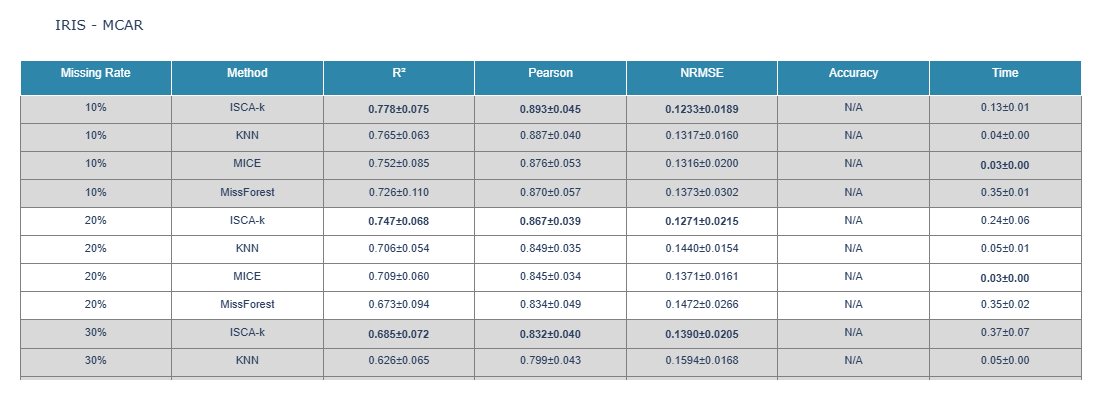

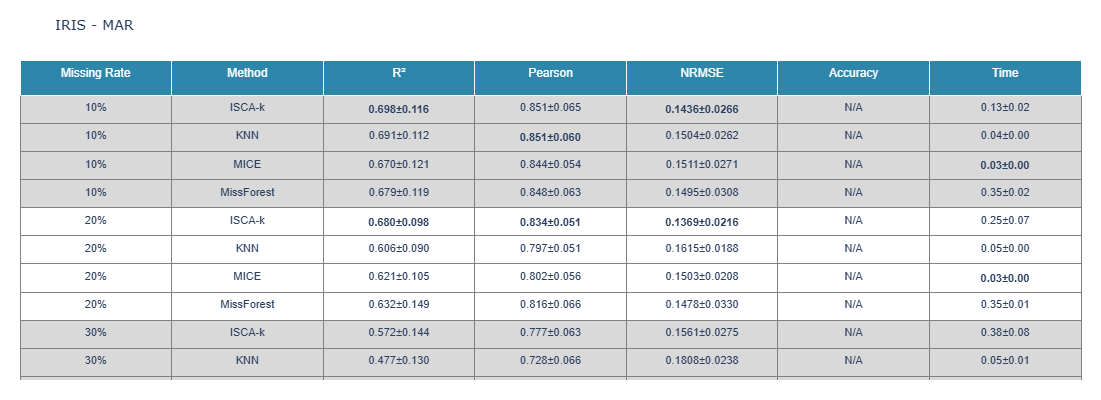

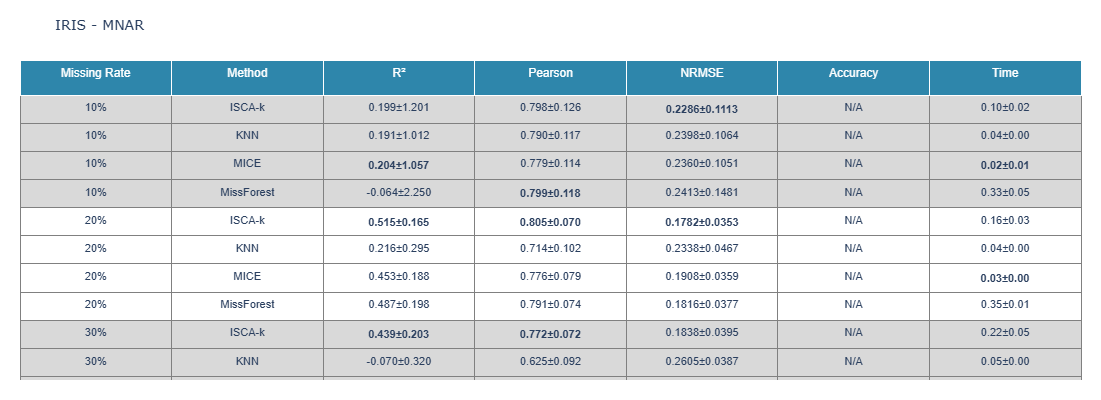

In [134]:
for mechanism in MECHANISMS:
    display_results_table(results_iris, mechanism, "IRIS")


TESTES ESTATÍSTICOS

MCAR - 30%:


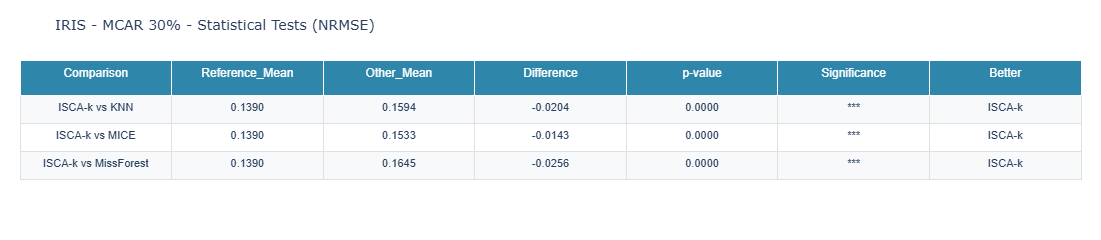


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 3/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MICE: p=0.0000 ***
  - vs MissForest: p=0.0000 ***

MAR - 30%:


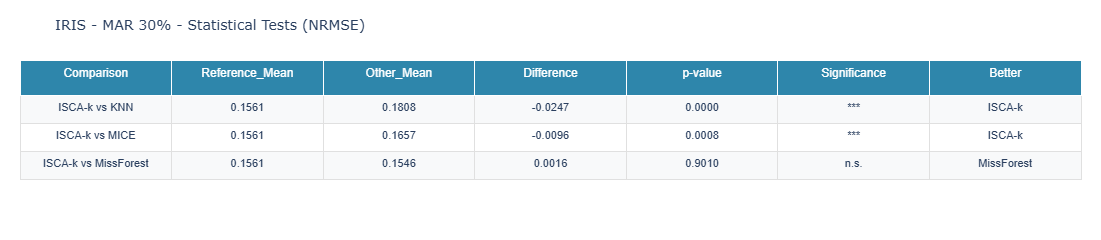


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 2/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MICE: p=0.0008 ***

MNAR - 30%:


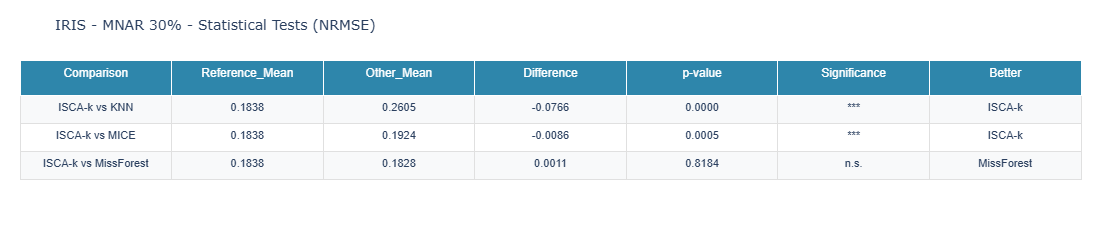


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 2/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MICE: p=0.0005 ***



TESTE DE FRIEDMAN - IRIS
MCAR 30% - NRMSE

Estatística: 49.2720
p-value: 0.0000
Resultado: DIFERENÇAS SIGNIFICATIVAS entre métodos (p < 0.05)

Ranking médio (1=melhor):
  ISCA-k: 1.46
  KNN: 2.92
  MICE: 2.50
  MissForest: 3.12

Ordem: ISCA-k > MICE > KNN > MissForest


In [151]:
print("\n" + "="*80)
print("TESTES ESTATÍSTICOS")
print("="*80)

# Wilcoxon para 30% em cada mecanismo
for mechanism in MECHANISMS:
    print(f"\n{mechanism} - 30%:")
    display_statistical_tests(results_iris, mechanism, 0.30, "IRIS", metric='NRMSE')

# Friedman test para 30% MCAR
print("\n")
display_friedman_results(results_iris, 'MCAR', 0.30, "IRIS", metric='NRMSE')


Gerando curvas de degradação...


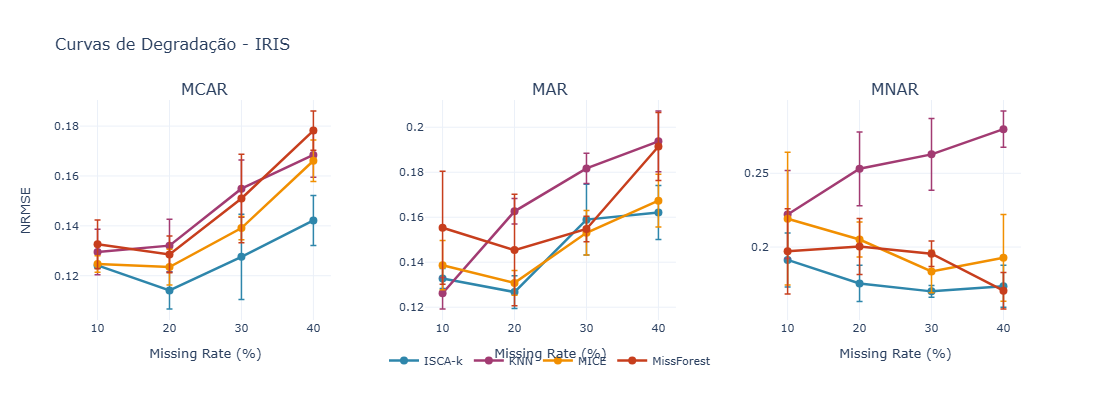

Gerando comparação de métodos...


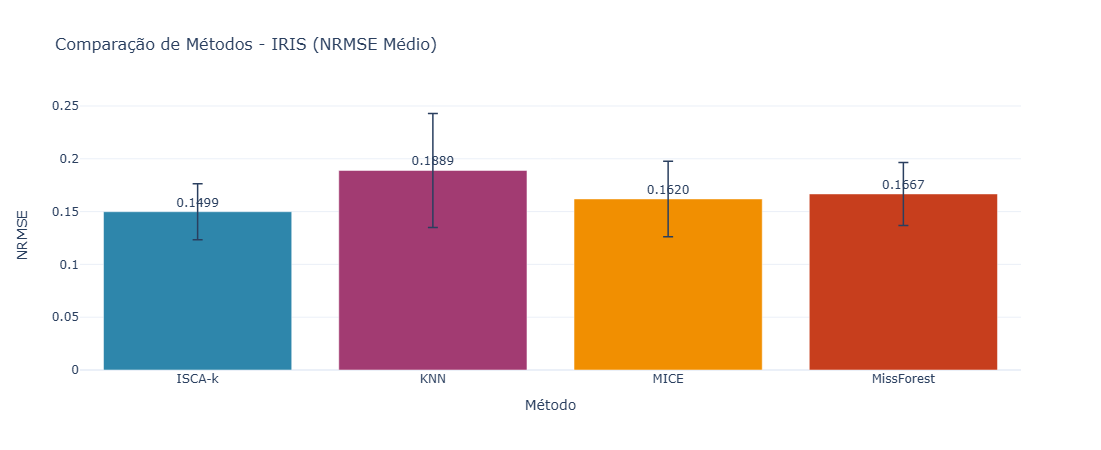

In [44]:
# Curvas de degradação
print("\nGerando curvas de degradação...")
plot_degradation_curves(results_iris, "IRIS", metric='NRMSE')

# Comparação de métodos
print("Gerando comparação de métodos...")
plot_method_comparison(results_iris, "IRIS")

##### WINE

In [158]:
from sklearn.datasets import load_wine
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [160]:
wine_data = load_wine()
data_wine = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)

print(f"\nShape original: {data_wine.shape}")
print(f"Tipos de dados:\n{data_wine.dtypes}")
print(f"\nMissings nativos: {data_wine.isna().sum().sum()}")

# Verificar que não há missings nativos
assert data_wine.isna().sum().sum() == 0, "Dataset tem missings nativos!"

print("\nDataset completo e limpo")
print(f"Shape final: {data_wine.shape}")
print(f"\nPrimeiras linhas:")
print(data_wine.head())
print(f"\nEstatísticas descritivas:")
print(data_wine.describe())


Shape original: (178, 13)
Tipos de dados:
alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object

Missings nativos: 0

Dataset completo e limpo
Shape final: (178, 13)

Primeiras linhas:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.

In [162]:
def impute_iscak_wine(data_missing):
    """ISCA-k para WINE (numérico puro)."""
    imputer = ISCAkCore(verbose=False)
    result = imputer.impute(
        data_missing,
        force_categorical=None,
        force_ordinal=None,
        interactive=False
    )
    return result

def impute_knn_wine(data_missing, k=5):
    """KNN com standardização para WINE."""
    # Calcular mean e std dos valores observados
    means = data_missing.mean()
    stds = data_missing.std()
    
    # Standardizar (mantém NaN)
    data_scaled = (data_missing - means) / stds
    
    # Imputa
    imputer = KNNImputer(n_neighbors=k)
    data_imputed_scaled = pd.DataFrame(
        imputer.fit_transform(data_scaled),
        columns=data_scaled.columns,
        index=data_scaled.index
    )
    
    # Inverse transform
    data_imputed = (data_imputed_scaled * stds) + means
    
    return data_imputed

def impute_mice_wine(data_missing, random_state=42):
    """MICE para WINE."""
    imputer = IterativeImputer(max_iter=10, random_state=random_state)
    data_imputed = pd.DataFrame(
        imputer.fit_transform(data_missing),
        columns=data_missing.columns,
        index=data_missing.index
    )
    return data_imputed

def impute_missforest_wine(data_missing, random_state=42):
    """MissForest para WINE."""
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10, random_state=random_state),
        max_iter=10,
        random_state=random_state
    )
    data_imputed = pd.DataFrame(
        imputer.fit_transform(data_missing),
        columns=data_missing.columns,
        index=data_missing.index
    )
    return data_imputed

print("\nISCA-k: sem configurações especiais")
print("KNN: k=[3,5,7,9,11], com standardização (mean/std dos observados)")
print("MICE: max_iter=10")
print("MissForest: n_estimators=10, max_iter=10")


ISCA-k: sem configurações especiais
KNN: k=[3,5,7,9,11], com standardização (mean/std dos observados)
MICE: max_iter=10
MissForest: n_estimators=10, max_iter=10


In [164]:
# Dicionário para armazenar resultados
results_wine = {}

for mechanism in MECHANISMS:
    print(f"\n{mechanism}:")
    
    for missing_rate in MISSING_RATES:
        print(f"  Missing rate {int(missing_rate*100)}%: ", end="")
        
        for run_idx, seed in enumerate(SEEDS):
            
            # Introduzir missings
            if mechanism == 'MCAR':
                data_missing = introduce_mcar(data_wine, missing_rate, seed)
            elif mechanism == 'MAR':
                data_missing = introduce_mar(data_wine, missing_rate, seed)
            else:
                data_missing = introduce_mnar(data_wine, missing_rate, seed)
            
            missing_mask = data_missing.isna()
            
            # Testar cada método
            for method in METHOD_ORDER:
                
                try:
                    start_time = time.time()
                    
                    if method == 'ISCA-k':
                        data_imputed = impute_iscak_wine(data_missing)
                    
                    elif method == 'KNN':
                        # Grid search: testar todos os k
                        best_result = None
                        best_metrics = None
                        best_k = None
                        
                        for k in [3, 5, 7, 9, 11]:
                            data_imputed_k = impute_knn_wine(data_missing, k=k)
                            metrics_k = calculate_metrics(data_wine, data_imputed_k, missing_mask)
                            
                            # Escolher k com melhor R²
                            if best_metrics is None or (not np.isnan(metrics_k['R2']) and metrics_k['R2'] > best_metrics['R2']):
                                best_result = data_imputed_k
                                best_metrics = metrics_k
                                best_k = k
                        
                        data_imputed = best_result
                        elapsed_time = time.time() - start_time
                        
                        # Adicionar info do melhor k
                        best_metrics['Time'] = elapsed_time
                        best_metrics['Best_k'] = best_k
                        
                        # Guardar resultado
                        key = (mechanism, missing_rate, method)
                        if key not in results_wine:
                            results_wine[key] = []
                        results_wine[key].append(best_metrics)
                        
                        continue  # Pular o código abaixo (já guardámos)
                    
                    elif method == 'MICE':
                        data_imputed = impute_mice_wine(data_missing, random_state=seed)
                    
                    else:  # MissForest
                        data_imputed = impute_missforest_wine(data_missing, random_state=seed)
                    
                    elapsed_time = time.time() - start_time
                    
                    # Calcular métricas
                    metrics = calculate_metrics(data_wine, data_imputed, missing_mask)
                    metrics['Time'] = elapsed_time
                    
                    # Guardar resultado
                    key = (mechanism, missing_rate, method)
                    if key not in results_wine:
                        results_wine[key] = []
                    results_wine[key].append(metrics)
                
                except Exception as e:
                    print(f"\nERRO em {method}: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
            
            print(".", end="", flush=True)
        
        print(" OK")



MCAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

MAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

MNAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK


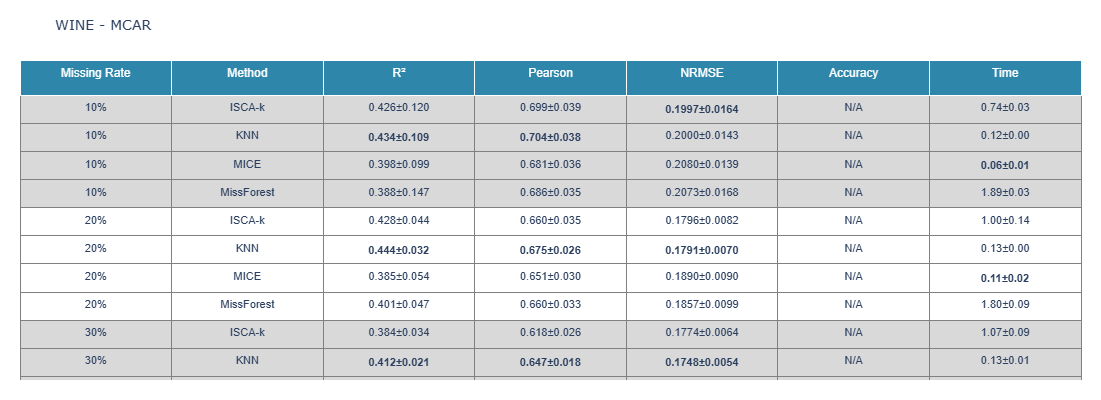

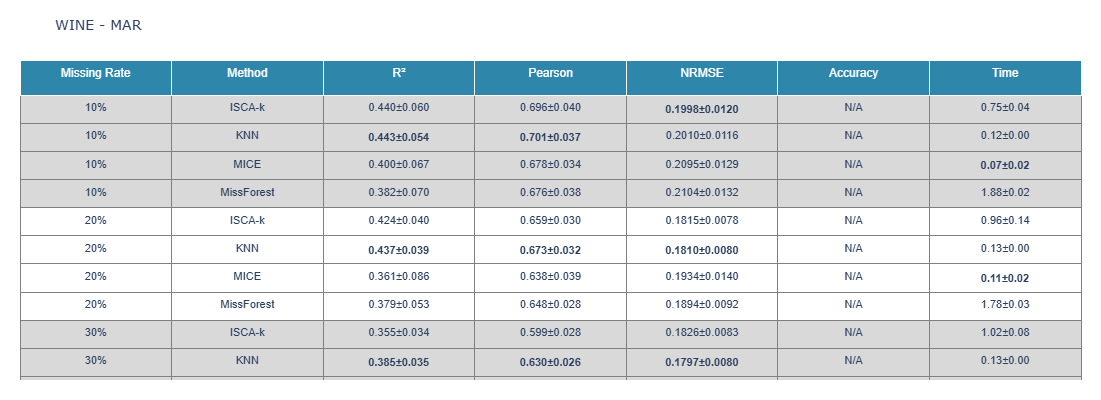

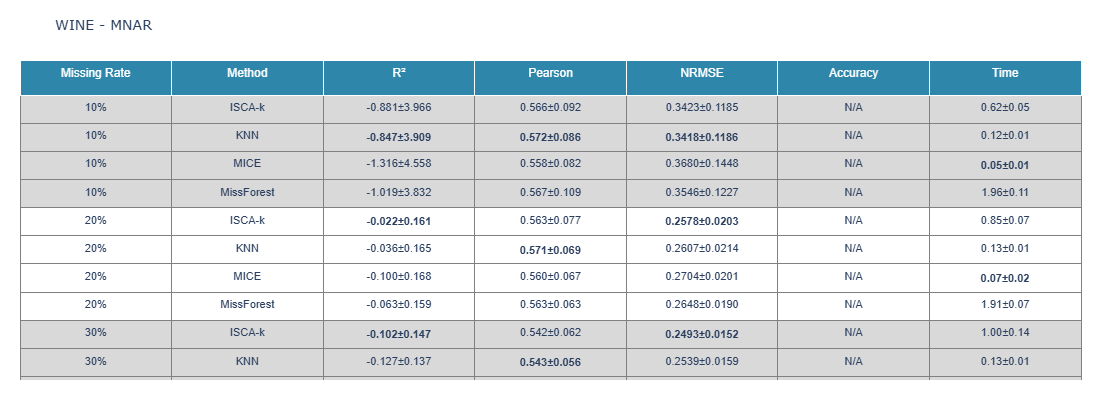

In [166]:
for mechanism in MECHANISMS:
    display_results_table(results_wine, mechanism, "WINE")


TESTES ESTATÍSTICOS

MCAR - 30%:


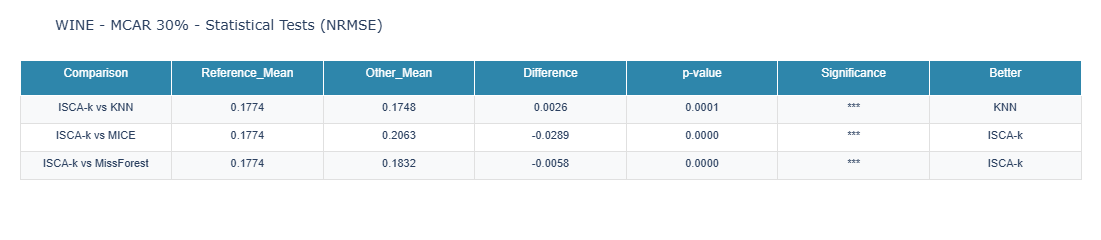


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 3/3 comparações:
  - vs KNN: p=0.0001 ***
  - vs MICE: p=0.0000 ***
  - vs MissForest: p=0.0000 ***

MAR - 30%:


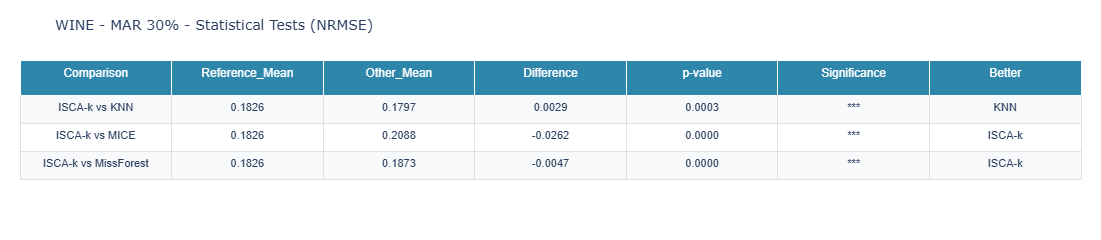


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 3/3 comparações:
  - vs KNN: p=0.0003 ***
  - vs MICE: p=0.0000 ***
  - vs MissForest: p=0.0000 ***

MNAR - 30%:


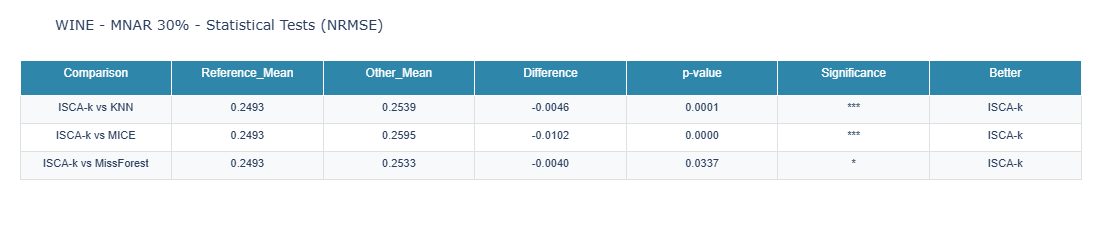


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 3/3 comparações:
  - vs KNN: p=0.0001 ***
  - vs MICE: p=0.0000 ***
  - vs MissForest: p=0.0337 *



TESTE DE FRIEDMAN - WINE
MCAR 30% - NRMSE

Estatística: 106.1040
p-value: 0.0000
Resultado: DIFERENÇAS SIGNIFICATIVAS entre métodos (p < 0.05)

Ranking médio (1=melhor):
  ISCA-k: 1.98
  KNN: 1.40
  MICE: 3.92
  MissForest: 2.70

Ordem: KNN > ISCA-k > MissForest > MICE


In [168]:
print("\n" + "="*80)
print("TESTES ESTATÍSTICOS")
print("="*80)

# Wilcoxon para 30% em cada mecanismo
for mechanism in MECHANISMS:
    print(f"\n{mechanism} - 30%:")
    display_statistical_tests(results_wine, mechanism, 0.30, "WINE", metric='NRMSE')

# Friedman test para 30% MCAR
print("\n")
display_friedman_results(results_wine, 'MCAR', 0.30, "WINE", metric='NRMSE')


Gerando curvas de degradação...


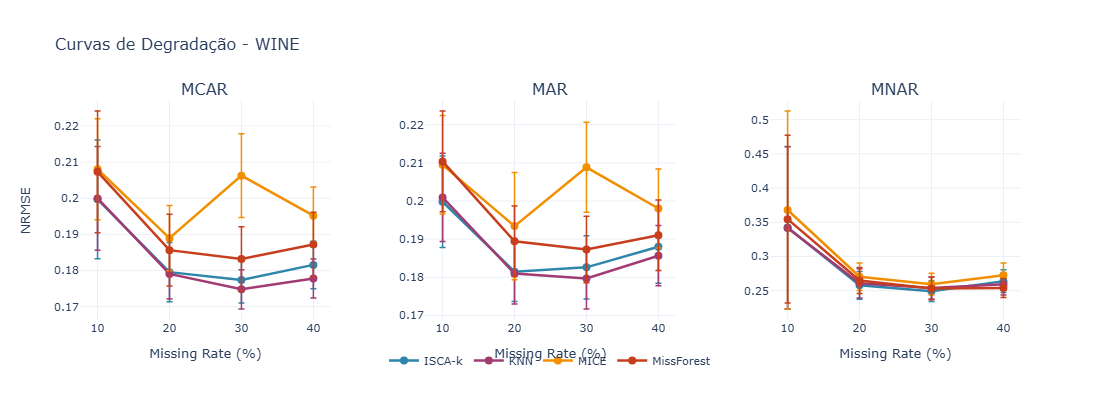

Gerando comparação de métodos...


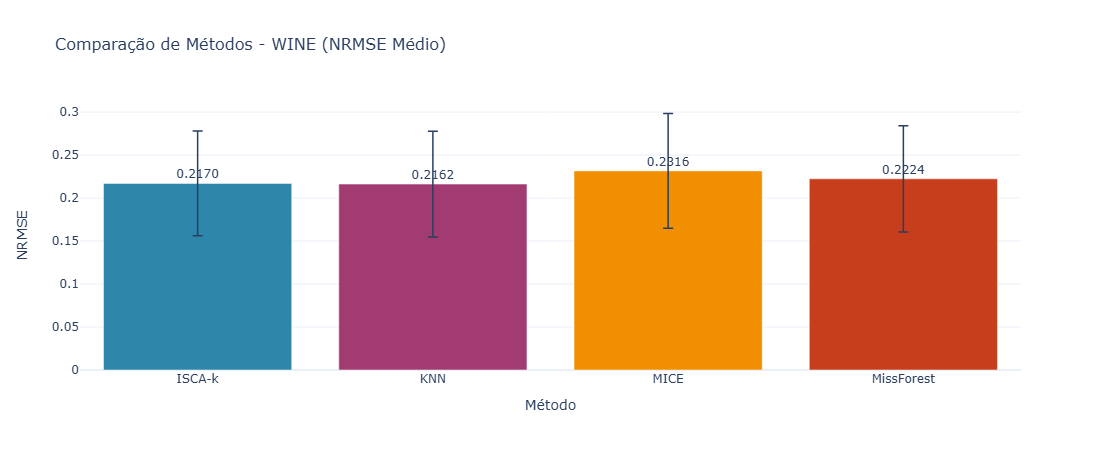

In [170]:
# Curvas de degradação
print("\nGerando curvas de degradação...")
plot_degradation_curves(results_wine, "WINE", metric='NRMSE')

# Comparação de métodos
print("Gerando comparação de métodos...")
plot_method_comparison(results_wine, "WINE")

##### SONAR

In [172]:
from sklearn.datasets import fetch_openml
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

print("Carregando SONAR do OpenML...")
sonar_data = fetch_openml('sonar', version=1, parser='auto', as_frame=True)
data_sonar = pd.DataFrame(sonar_data.data).select_dtypes(include=[np.number])

print(f"\nShape original: {data_sonar.shape}")
print(f"Tipos de dados:\n{data_sonar.dtypes.value_counts()}")
print(f"\nMissings nativos: {data_sonar.isna().sum().sum()}")

# Remover missings nativos se existirem
if data_sonar.isna().sum().sum() > 0:
    print(f"Removendo {data_sonar.isna().sum().sum()} missings nativos...")
    data_sonar = data_sonar.dropna()
    data_sonar = data_sonar.reset_index(drop=True)

# Verificar que não há missings nativos
assert data_sonar.isna().sum().sum() == 0, "Dataset tem missings nativos!"


Carregando SONAR do OpenML...

Shape original: (208, 60)
Tipos de dados:
float64    60
Name: count, dtype: int64

Missings nativos: 0


In [174]:
def impute_iscak_sonar(data_missing):
    """ISCA-k para SONAR (numérico puro)."""
    imputer = ISCAkCore(verbose=False)
    result = imputer.impute(
        data_missing,
        force_categorical=None,
        force_ordinal=None,
        interactive=False
    )
    return result

def impute_knn_sonar(data_missing, k=5):
    """KNN com standardização para SONAR."""
    # Calcular mean e std dos valores observados
    means = data_missing.mean()
    stds = data_missing.std()
    
    # Standardizar (mantém NaN)
    data_scaled = (data_missing - means) / stds
    
    # Imputa
    imputer = KNNImputer(n_neighbors=k)
    data_imputed_scaled = pd.DataFrame(
        imputer.fit_transform(data_scaled),
        columns=data_scaled.columns,
        index=data_scaled.index
    )
    
    # Inverse transform
    data_imputed = (data_imputed_scaled * stds) + means
    
    return data_imputed

def impute_mice_sonar(data_missing, random_state=42):
    """MICE para SONAR."""
    imputer = IterativeImputer(max_iter=10, random_state=random_state)
    data_imputed = pd.DataFrame(
        imputer.fit_transform(data_missing),
        columns=data_missing.columns,
        index=data_missing.index
    )
    return data_imputed

def impute_missforest_sonar(data_missing, random_state=42):
    """MissForest para SONAR."""
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10, random_state=random_state),
        max_iter=10,
        random_state=random_state
    )
    data_imputed = pd.DataFrame(
        imputer.fit_transform(data_missing),
        columns=data_missing.columns,
        index=data_missing.index
    )
    return data_imputed

print("\nISCA-k: sem configurações especiais")
print("KNN: k=[3,5,7,9,11], com standardização (mean/std dos observados)")
print("MICE: max_iter=10")
print("MissForest: n_estimators=10, max_iter=10")


ISCA-k: sem configurações especiais
KNN: k=[3,5,7,9,11], com standardização (mean/std dos observados)
MICE: max_iter=10
MissForest: n_estimators=10, max_iter=10


In [176]:
# Dicionário para armazenar resultados
results_sonar = {}

for mechanism in MECHANISMS:
    print(f"\n{mechanism}:")
    
    for missing_rate in MISSING_RATES:
        print(f"  Missing rate {int(missing_rate*100)}%: ", end="")
        
        for run_idx, seed in enumerate(SEEDS):
            
            # Introduzir missings
            if mechanism == 'MCAR':
                data_missing = introduce_mcar(data_sonar, missing_rate, seed)
            elif mechanism == 'MAR':
                data_missing = introduce_mar(data_sonar, missing_rate, seed)
            else:
                data_missing = introduce_mnar(data_sonar, missing_rate, seed)
            
            missing_mask = data_missing.isna()
            
            # Testar cada método
            for method in METHOD_ORDER:
                
                try:
                    start_time = time.time()
                    
                    if method == 'ISCA-k':
                        data_imputed = impute_iscak_sonar(data_missing)
                    
                    elif method == 'KNN':
                        # Grid search: testar todos os k
                        best_result = None
                        best_metrics = None
                        best_k = None
                        
                        for k in [3, 5, 7, 9, 11]:
                            data_imputed_k = impute_knn_sonar(data_missing, k=k)
                            metrics_k = calculate_metrics(data_sonar, data_imputed_k, missing_mask)
                            
                            # Escolher k com melhor R²
                            if best_metrics is None or (not np.isnan(metrics_k['R2']) and metrics_k['R2'] > best_metrics['R2']):
                                best_result = data_imputed_k
                                best_metrics = metrics_k
                                best_k = k
                        
                        data_imputed = best_result
                        elapsed_time = time.time() - start_time
                        
                        # Adicionar info do melhor k
                        best_metrics['Time'] = elapsed_time
                        best_metrics['Best_k'] = best_k
                        
                        # Guardar resultado
                        key = (mechanism, missing_rate, method)
                        if key not in results_sonar:
                            results_sonar[key] = []
                        results_sonar[key].append(best_metrics)
                        
                        continue  # Pular o código abaixo (já guardámos)
                    
                    elif method == 'MICE':
                        data_imputed = impute_mice_sonar(data_missing, random_state=seed)
                    
                    else:  # MissForest
                        data_imputed = impute_missforest_sonar(data_missing, random_state=seed)
                    
                    elapsed_time = time.time() - start_time
                    
                    # Calcular métricas
                    metrics = calculate_metrics(data_sonar, data_imputed, missing_mask)
                    metrics['Time'] = elapsed_time
                    
                    # Guardar resultado
                    key = (mechanism, missing_rate, method)
                    if key not in results_sonar:
                        results_sonar[key] = []
                    results_sonar[key].append(metrics)
                
                except Exception as e:
                    print(f"\nERRO em {method}: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
            
            print(".", end="", flush=True)
        
        print(" OK")


MCAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

MAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

MNAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK


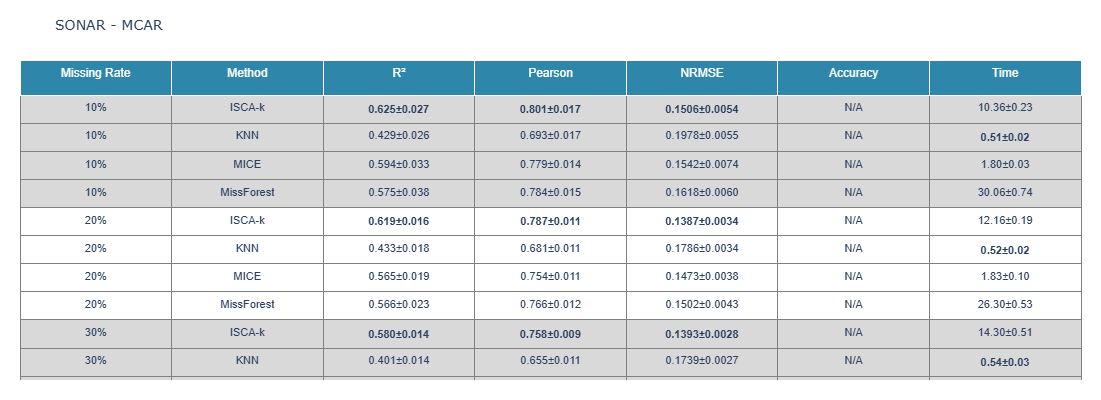

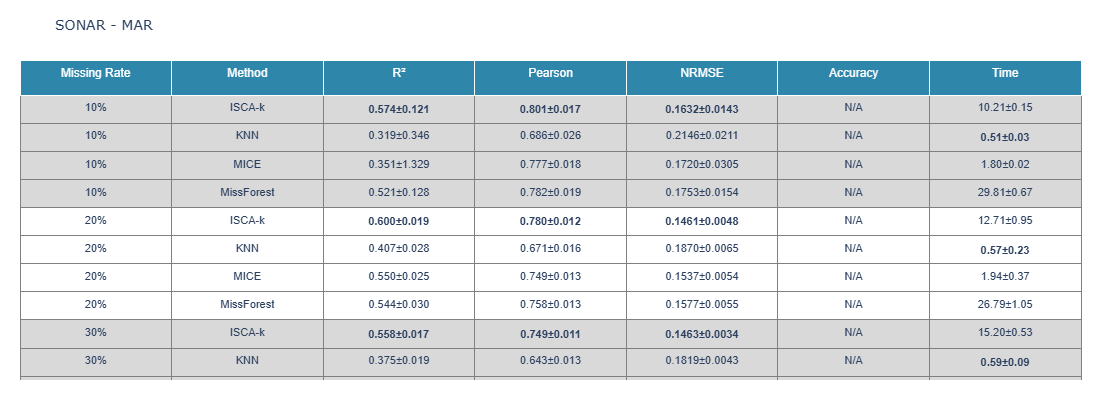

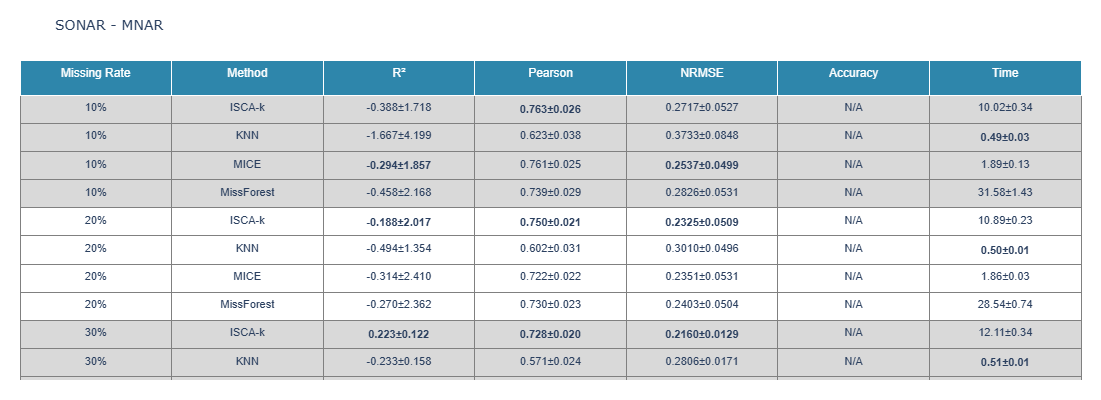

In [178]:
for mechanism in MECHANISMS:
    display_results_table(results_sonar, mechanism, "SONAR")


TESTES ESTATÍSTICOS

MCAR - 30%:


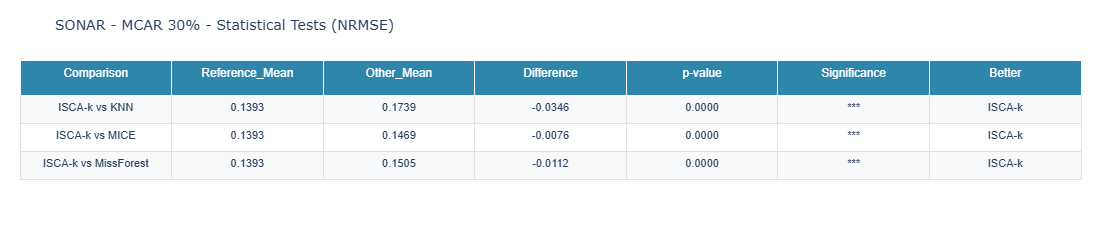


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 3/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MICE: p=0.0000 ***
  - vs MissForest: p=0.0000 ***

MAR - 30%:


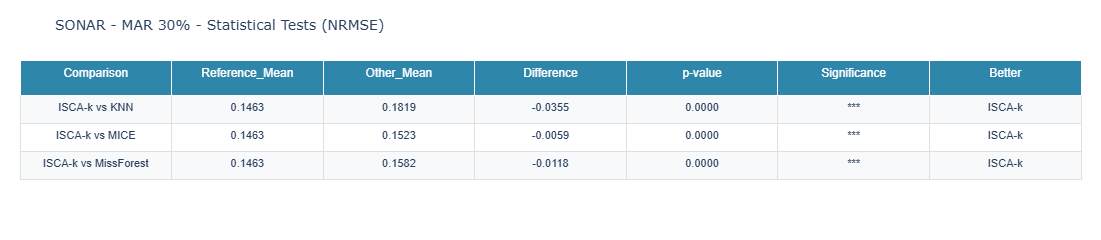


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 3/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MICE: p=0.0000 ***
  - vs MissForest: p=0.0000 ***

MNAR - 30%:


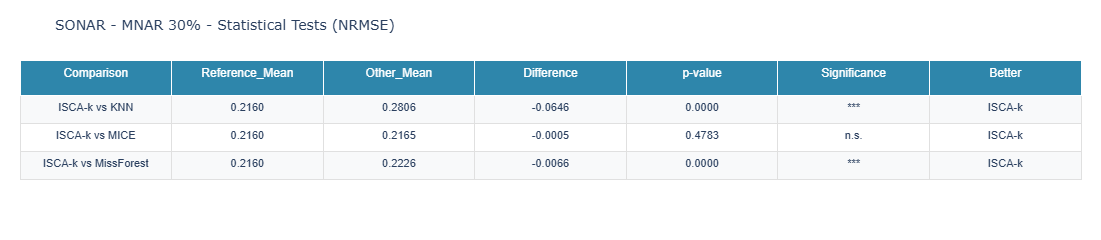


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 2/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MissForest: p=0.0000 ***



TESTE DE FRIEDMAN - SONAR
MCAR 30% - NRMSE

Estatística: 145.5840
p-value: 0.0000
Resultado: DIFERENÇAS SIGNIFICATIVAS entre métodos (p < 0.05)

Ranking médio (1=melhor):
  ISCA-k: 1.00
  KNN: 4.00
  MICE: 2.08
  MissForest: 2.92

Ordem: ISCA-k > MICE > MissForest > KNN


In [180]:
print("\n" + "="*80)
print("TESTES ESTATÍSTICOS")
print("="*80)

# Wilcoxon para 30% em cada mecanismo
for mechanism in MECHANISMS:
    print(f"\n{mechanism} - 30%:")
    display_statistical_tests(results_sonar, mechanism, 0.30, "SONAR", metric='NRMSE')

# Friedman test para 30% MCAR
print("\n")
display_friedman_results(results_sonar, 'MCAR', 0.30, "SONAR", metric='NRMSE')

##### DIABETES

In [182]:
from sklearn.datasets import load_diabetes
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Importar o teu método
from iscak_core import ISCAkCore

In [184]:
diabetes_data = load_diabetes()
data_diabetes = pd.DataFrame(diabetes_data.data, columns=diabetes_data.feature_names)

print(f"\nShape original: {data_diabetes.shape}")
print(f"Tipos de dados:\n{data_diabetes.dtypes}")
print(f"\nMissings nativos: {data_diabetes.isna().sum().sum()}")

# Verificar que não há missings nativos
assert data_diabetes.isna().sum().sum() == 0, "Dataset tem missings nativos!"

print("\nDataset completo e limpo")
print(f"Shape final: {data_diabetes.shape}")
print(f"\nPrimeiras linhas:")
print(data_diabetes.head())
print(f"\nEstatísticas descritivas:")
print(data_diabetes.describe())


Shape original: (442, 10)
Tipos de dados:
age    float64
sex    float64
bmi    float64
bp     float64
s1     float64
s2     float64
s3     float64
s4     float64
s5     float64
s6     float64
dtype: object

Missings nativos: 0

Dataset completo e limpo
Shape final: (442, 10)

Primeiras linhas:
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  

Estatísticas descritivas:
                age   

In [186]:
def impute_iscak_diabetes(data_missing):
    """ISCA-k para DIABETES (numérico puro)."""
    imputer = ISCAkCore(verbose=False)
    result = imputer.impute(
        data_missing,
        force_categorical=None,
        force_ordinal=None,
        interactive=False
    )
    return result

def impute_knn_diabetes(data_missing, k=5):
    """KNN com standardização para DIABETES."""
    # Calcular mean e std dos valores observados
    means = data_missing.mean()
    stds = data_missing.std()
    
    # Standardizar (mantém NaN)
    data_scaled = (data_missing - means) / stds
    
    # Imputa
    imputer = KNNImputer(n_neighbors=k)
    data_imputed_scaled = pd.DataFrame(
        imputer.fit_transform(data_scaled),
        columns=data_scaled.columns,
        index=data_scaled.index
    )
    
    # Inverse transform
    data_imputed = (data_imputed_scaled * stds) + means
    
    return data_imputed

def impute_mice_diabetes(data_missing, random_state=42):
    """MICE para DIABETES."""
    imputer = IterativeImputer(max_iter=10, random_state=random_state)
    data_imputed = pd.DataFrame(
        imputer.fit_transform(data_missing),
        columns=data_missing.columns,
        index=data_missing.index
    )
    return data_imputed

def impute_missforest_diabetes(data_missing, random_state=42):
    """MissForest para DIABETES."""
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10, random_state=random_state),
        max_iter=10,
        random_state=random_state
    )
    data_imputed = pd.DataFrame(
        imputer.fit_transform(data_missing),
        columns=data_missing.columns,
        index=data_missing.index
    )
    return data_imputed

print("\nISCA-k: sem configurações especiais")
print("KNN: k=[3,5,7,9,11], com standardização (mean/std dos observados)")
print("MICE: max_iter=10")
print("MissForest: n_estimators=10, max_iter=10")


ISCA-k: sem configurações especiais
KNN: k=[3,5,7,9,11], com standardização (mean/std dos observados)
MICE: max_iter=10
MissForest: n_estimators=10, max_iter=10


In [188]:
# Dicionário para armazenar resultados
results_diabetes = {}

for mechanism in MECHANISMS:
    print(f"\n{mechanism}:")
    
    for missing_rate in MISSING_RATES:
        print(f"  Missing rate {int(missing_rate*100)}%: ", end="")
        
        for run_idx, seed in enumerate(SEEDS):
            
            # Introduzir missings
            if mechanism == 'MCAR':
                data_missing = introduce_mcar(data_diabetes, missing_rate, seed)
            elif mechanism == 'MAR':
                data_missing = introduce_mar(data_diabetes, missing_rate, seed)
            else:
                data_missing = introduce_mnar(data_diabetes, missing_rate, seed)
            
            missing_mask = data_missing.isna()
            
            # Testar cada método
            for method in METHOD_ORDER:
                
                try:
                    start_time = time.time()
                    
                    if method == 'ISCA-k':
                        data_imputed = impute_iscak_diabetes(data_missing)
                    
                    elif method == 'KNN':
                        # Grid search: testar todos os k
                        best_result = None
                        best_metrics = None
                        best_k = None
                        
                        for k in [3, 5, 7, 9, 11]:
                            data_imputed_k = impute_knn_diabetes(data_missing, k=k)
                            metrics_k = calculate_metrics(data_diabetes, data_imputed_k, missing_mask)
                            
                            # Escolher k com melhor R²
                            if best_metrics is None or (not np.isnan(metrics_k['R2']) and metrics_k['R2'] > best_metrics['R2']):
                                best_result = data_imputed_k
                                best_metrics = metrics_k
                                best_k = k
                        
                        data_imputed = best_result
                        elapsed_time = time.time() - start_time
                        
                        # Adicionar info do melhor k
                        best_metrics['Time'] = elapsed_time
                        best_metrics['Best_k'] = best_k
                        
                        # Guardar resultado
                        key = (mechanism, missing_rate, method)
                        if key not in results_diabetes:
                            results_diabetes[key] = []
                        results_diabetes[key].append(best_metrics)
                        
                        continue  # Pular o código abaixo (já guardámos)
                    
                    elif method == 'MICE':
                        data_imputed = impute_mice_diabetes(data_missing, random_state=seed)
                    
                    else:  # MissForest
                        data_imputed = impute_missforest_diabetes(data_missing, random_state=seed)
                    
                    elapsed_time = time.time() - start_time
                    
                    # Calcular métricas
                    metrics = calculate_metrics(data_diabetes, data_imputed, missing_mask)
                    metrics['Time'] = elapsed_time
                    
                    # Guardar resultado
                    key = (mechanism, missing_rate, method)
                    if key not in results_diabetes:
                        results_diabetes[key] = []
                    results_diabetes[key].append(metrics)
                
                except Exception as e:
                    print(f"\nERRO em {method}: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
            
            print(".", end="", flush=True)
        
        print(" OK")



MCAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

MAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

MNAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK


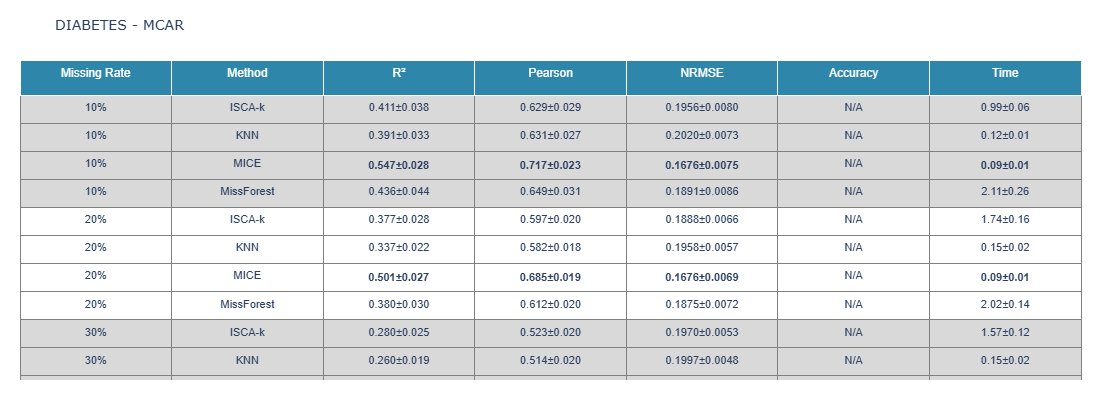

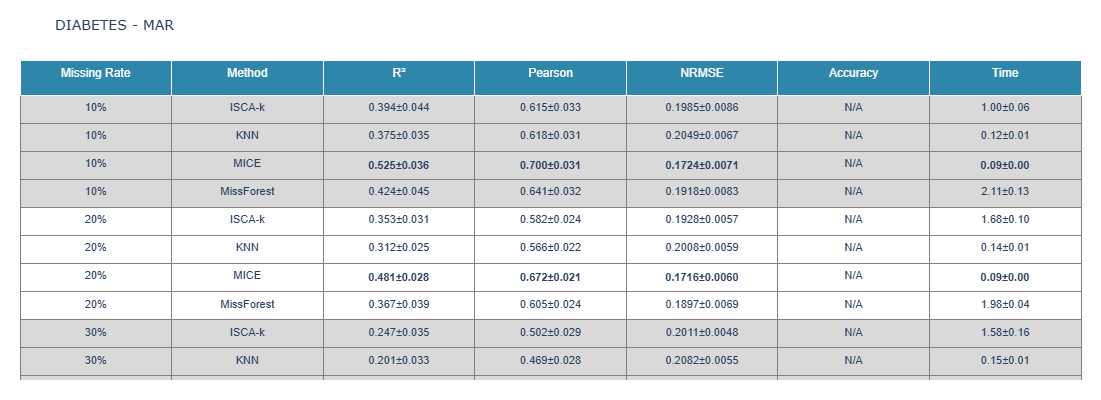

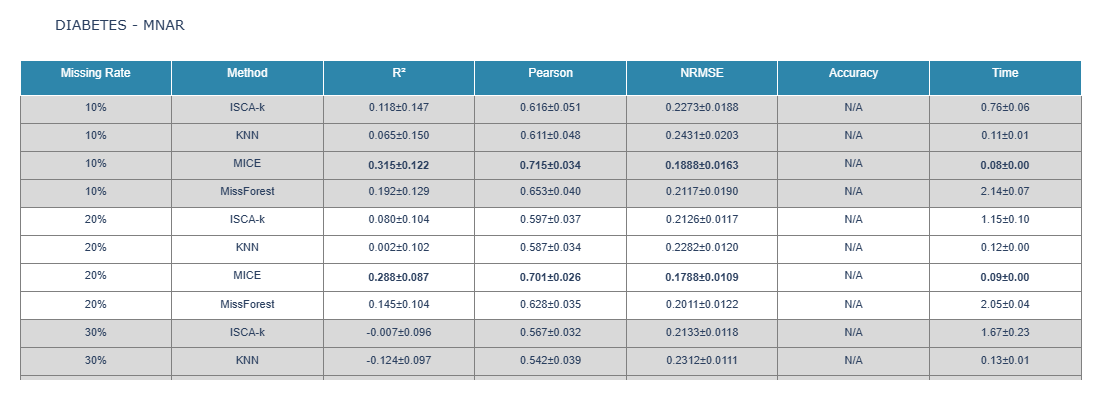

In [190]:
for mechanism in MECHANISMS:
    display_results_table(results_diabetes, mechanism, "DIABETES")


MCAR - 30%:


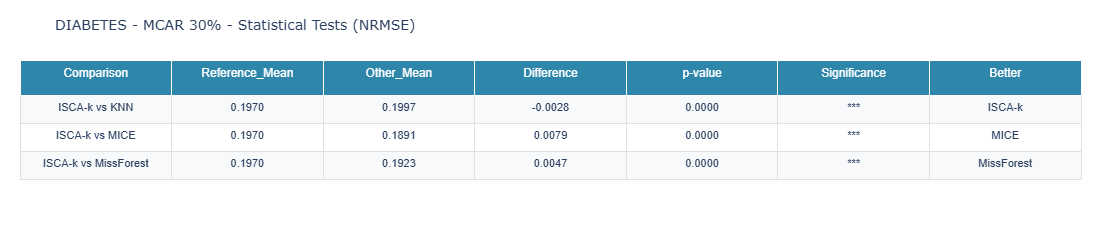


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 3/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MICE: p=0.0000 ***
  - vs MissForest: p=0.0000 ***

MAR - 30%:


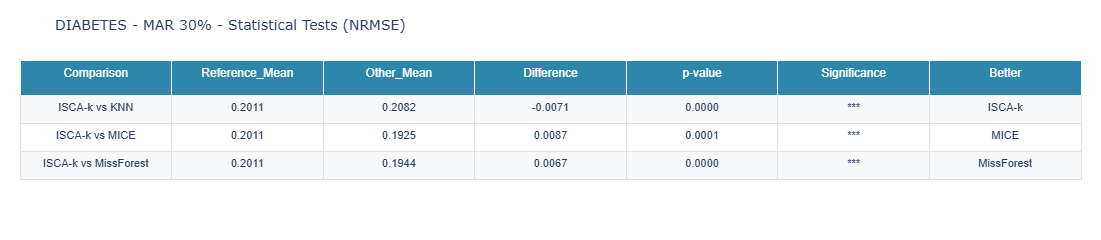


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 3/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MICE: p=0.0001 ***
  - vs MissForest: p=0.0000 ***

MNAR - 30%:


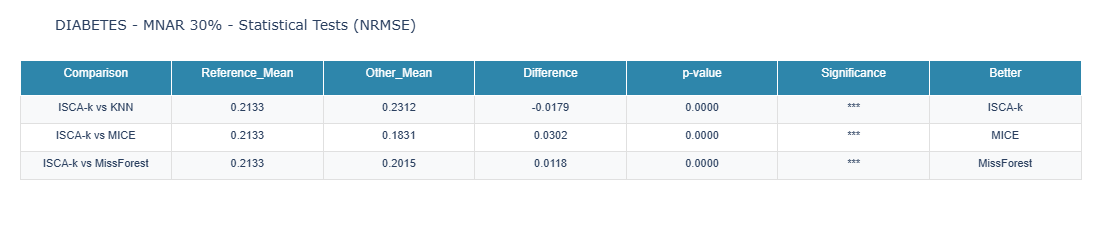


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 3/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MICE: p=0.0000 ***
  - vs MissForest: p=0.0000 ***



TESTE DE FRIEDMAN - DIABETES
MCAR 30% - NRMSE

Estatística: 70.9680
p-value: 0.0000
Resultado: DIFERENÇAS SIGNIFICATIVAS entre métodos (p < 0.05)

Ranking médio (1=melhor):
  ISCA-k: 2.82
  KNN: 3.60
  MICE: 1.94
  MissForest: 1.64

Ordem: MissForest > MICE > ISCA-k > KNN


In [196]:
# Wilcoxon para 30% em cada mecanismo
for mechanism in MECHANISMS:
    print(f"\n{mechanism} - 30%:")
    display_statistical_tests(results_diabetes, mechanism, 0.30, "DIABETES", metric='NRMSE')

# Friedman test para 30% MCAR
print("\n")
display_friedman_results(results_diabetes, 'MCAR', 0.30, "DIABETES", metric='NRMSE')



Gerando curvas de degradação...


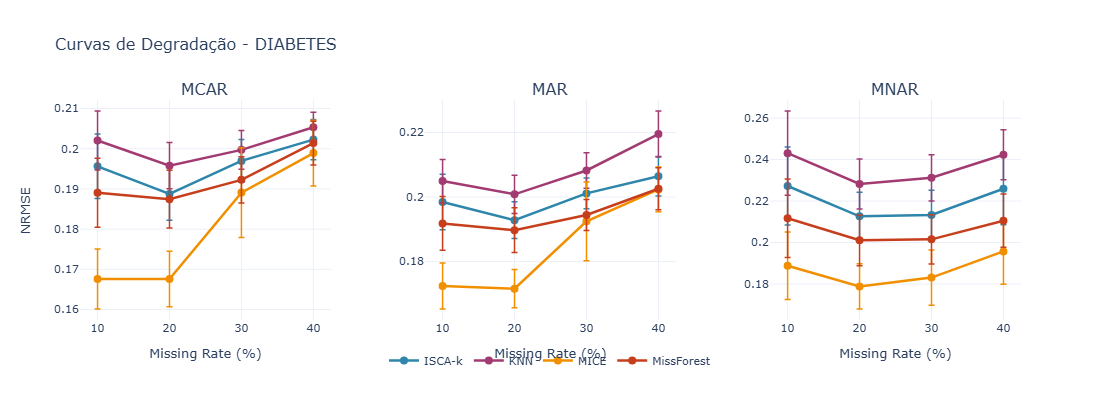

Gerando comparação de métodos...


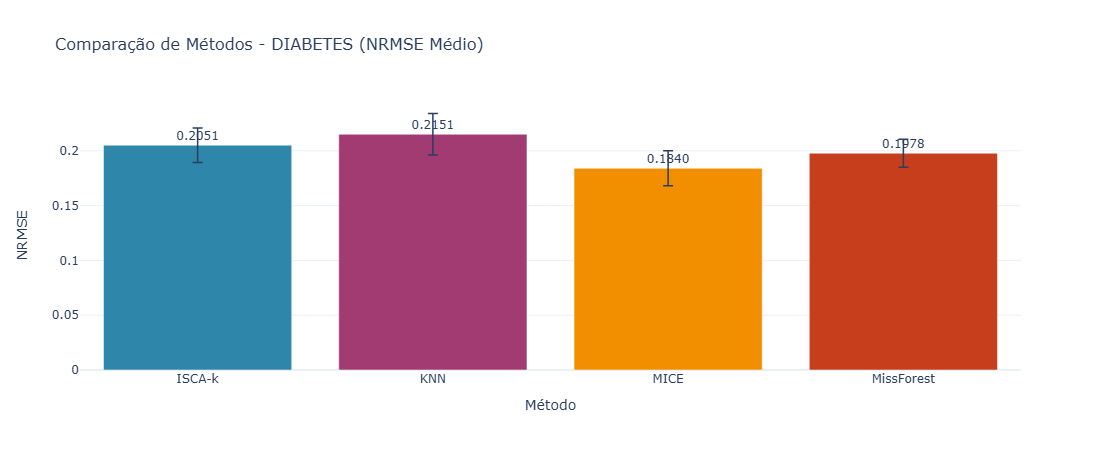

In [194]:
# Curvas de degradação
print("\nGerando curvas de degradação...")
plot_degradation_curves(results_diabetes, "DIABETES", metric='NRMSE')

# Comparação de métodos
print("Gerando comparação de métodos...")
plot_method_comparison(results_diabetes, "DIABETES")

#### Datasets Mistos

##### TITANIC

In [198]:
import pandas as pd
import numpy as np
import time
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [200]:
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data_titanic_raw = pd.read_csv(url)

print(f"\nShape original: {data_titanic_raw.shape}")
print(f"\nColunas: {list(data_titanic_raw.columns)}")
print(f"\nTipos originais:\n{data_titanic_raw.dtypes}")

# Selecionar features relevantes e remover linhas com missings nativos
# Features a usar: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked
features_to_use = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

data_titanic = data_titanic_raw[features_to_use].copy()

print(f"\nMissings nativos por coluna:")
print(data_titanic.isna().sum())

# Remover linhas com missings nativos (Age, Fare, Embarked)
# Para ter dataset completo para introduzir missings artificiais
data_titanic_complete = data_titanic.dropna()

print(f"\nShape após remover missings nativos: {data_titanic_complete.shape}")
print(f"Missings restantes: {data_titanic_complete.isna().sum().sum()}")

# Verificar
assert data_titanic_complete.isna().sum().sum() == 0, "Dataset ainda tem missings!"

print("\n✓ Dataset completo e limpo")
print(f"Shape final: {data_titanic_complete.shape}")
print(f"\nTipos finais:")
print(data_titanic_complete.dtypes)
print(f"\nPrimeiras linhas:")
print(data_titanic_complete.head())
print(f"\nEstatísticas descritivas (numéricas):")
print(data_titanic_complete.describe())
print(f"\nDistribuição categóricas:")
print(f"  Sex: {data_titanic_complete['Sex'].value_counts().to_dict()}")
print(f"  Embarked: {data_titanic_complete['Embarked'].value_counts().to_dict()}")
print(f"  Pclass: {data_titanic_complete['Pclass'].value_counts().to_dict()}")



Shape original: (891, 12)

Colunas: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Tipos originais:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missings nativos por coluna:
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Shape após remover missings nativos: (712, 7)
Missings restantes: 0

✓ Dataset completo e limpo
Shape final: (712, 7)

Tipos finais:
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

Primeiras linhas:
   Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  2

In [202]:
force_categorical_titanic = None  # Sex e Embarked já são object, serão detectadas

force_ordinal_titanic = {
    'Pclass': [1, 2, 3]  # Ordem: 1ª classe > 2ª > 3ª (em termos de qualidade)
}

print("\nforce_categorical:", force_categorical_titanic)
print("force_ordinal:", force_ordinal_titanic)
print("\nVariáveis detectadas automaticamente:")
print("  - Sex: nominal (binária)")
print("  - Embarked: nominal (C/Q/S)")
print("  - Age, SibSp, Parch, Fare: numéricas")


force_categorical: None
force_ordinal: {'Pclass': [1, 2, 3]}

Variáveis detectadas automaticamente:
  - Sex: nominal (binária)
  - Embarked: nominal (C/Q/S)
  - Age, SibSp, Parch, Fare: numéricas


In [268]:
def impute_iscak_titanic(data_missing):
    """ISCA-k para TITANIC (misto)."""
    imputer = ISCAkCore(verbose=False)
    result = imputer.impute(
        data_missing,
        force_categorical=force_categorical_titanic,
        force_ordinal=force_ordinal_titanic,
        interactive=False
    )
    return result

def impute_knn_titanic(data_missing, k=5):
    """
    KNN para TITANIC (misto).
    
    Estratégia: 
    1. Label encode categóricas
    2. One-hot encode para KNN  
    3. Imputa
    4. Reverte para tipos ORIGINAIS (Sex/Embarked=string, Pclass=int)
    """
    # Definir colunas por tipo (conforme dataset original)
    numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']
    ordinal_cols = ['Pclass']  # int ordinal
    nominal_cols = ['Sex', 'Embarked']  # string nominal
    
    # Label encode TODAS as categóricas
    data_encoded = data_missing.copy()
    label_mappings = {}
    
    for col in ordinal_cols + nominal_cols:
        unique_vals = data_encoded[col].dropna().unique()
        mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
        reverse_mapping = {idx: val for val, idx in mapping.items()}
        label_mappings[col] = mapping
        label_mappings[f'{col}_reverse'] = reverse_mapping
        
        # Encode
        data_encoded[col] = data_encoded[col].map(mapping)
    
    # One-hot encode para KNN
    encoded_dfs = []
    
    for col in ordinal_cols + nominal_cols:
        dummies = pd.get_dummies(data_encoded[col], prefix=col, drop_first=False, dtype=float)
        # Propagar NaN
        mask = data_encoded[col].isna()
        dummies.loc[mask, :] = np.nan
        encoded_dfs.append(dummies)
    
    # Combinar numéricas + dummies
    data_for_knn = pd.concat(
        [data_encoded[numeric_cols]] + encoded_dfs,
        axis=1
    )
    
    # Standardizar APENAS numéricas
    means = data_for_knn[numeric_cols].mean()
    stds = data_for_knn[numeric_cols].std().replace(0, 1)
    data_for_knn[numeric_cols] = (data_for_knn[numeric_cols] - means) / stds
    
    # Imputar
    imputer = KNNImputer(n_neighbors=k, weights='distance')
    data_imputed_array = imputer.fit_transform(data_for_knn)
    data_imputed_knn = pd.DataFrame(
        data_imputed_array,
        columns=data_for_knn.columns,
        index=data_for_knn.index
    )
    
    # Inverse transform numéricas
    data_imputed_knn[numeric_cols] = (data_imputed_knn[numeric_cols] * stds) + means
    
    # Construir resultado
    result = pd.DataFrame(index=data_missing.index)
    
    # Copiar numéricas
    result[numeric_cols] = data_imputed_knn[numeric_cols]
    
    # Reverter categóricas para valores ORIGINAIS
    for col in ordinal_cols + nominal_cols:
        dummy_cols = [c for c in data_imputed_knn.columns if c.startswith(f"{col}_")]
        if len(dummy_cols) > 0:
            # Índice da dummy com maior valor
            dummy_values = data_imputed_knn[dummy_cols].values
            max_indices = dummy_values.argmax(axis=1)
            
            # Reverter para valores originais
            reverse_map = label_mappings[f'{col}_reverse']
            result[col] = [reverse_map[idx] for idx in max_indices]
    
    # Garantir ordem e tipos corretos
    result = result[data_missing.columns]
    
    # Pclass deve ser int
    if 'Pclass' in result.columns:
        result['Pclass'] = result['Pclass'].astype(int)
    
    return result

def impute_mice_titanic(data_missing, random_state=42):
    """MICE para TITANIC - BayesianRidge."""
    data_encoded = data_missing.copy()
    label_mappings = {}
    categorical_cols = ['Sex', 'Embarked', 'Pclass']
    
    for col in categorical_cols:
        unique_vals = data_encoded[col].dropna().unique()
        mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
        reverse_mapping = {idx: val for val, idx in mapping.items()}
        label_mappings[col] = mapping
        label_mappings[f'{col}_reverse'] = reverse_mapping
        data_encoded[col] = data_encoded[col].map(mapping)
    
    imputer = IterativeImputer(max_iter=10, random_state=random_state)
    data_imputed_array = imputer.fit_transform(data_encoded)
    data_imputed = pd.DataFrame(data_imputed_array, columns=data_encoded.columns, index=data_encoded.index)
    
    for col in categorical_cols:
        n_classes = len(label_mappings[col])
        data_imputed[col] = data_imputed[col].round().clip(0, n_classes - 1).astype(int)
        reverse_map = label_mappings[f'{col}_reverse']
        data_imputed[col] = data_imputed[col].map(reverse_map)
    
    if 'Pclass' in data_imputed.columns:
        data_imputed['Pclass'] = data_imputed['Pclass'].astype(int)
    
    return data_imputed

def impute_missforest_titanic(data_missing, random_state=42):
    """MissForest para TITANIC - RandomForest."""
    data_encoded = data_missing.copy()
    label_mappings = {}
    categorical_cols = ['Sex', 'Embarked', 'Pclass']
    
    for col in categorical_cols:
        unique_vals = data_encoded[col].dropna().unique()
        mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
        reverse_mapping = {idx: val for val, idx in mapping.items()}
        label_mappings[col] = mapping
        label_mappings[f'{col}_reverse'] = reverse_mapping
        data_encoded[col] = data_encoded[col].map(mapping)
    
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10, random_state=random_state),
        max_iter=10, sample_posterior=False, random_state=random_state
    )
    data_imputed_array = imputer.fit_transform(data_encoded)
    data_imputed = pd.DataFrame(data_imputed_array, columns=data_encoded.columns, index=data_encoded.index)
    
    for col in categorical_cols:
        n_classes = len(label_mappings[col])
        data_imputed[col] = data_imputed[col].round().clip(0, n_classes - 1).astype(int)
        reverse_map = label_mappings[f'{col}_reverse']
        data_imputed[col] = data_imputed[col].map(reverse_map)
    
    if 'Pclass' in data_imputed.columns:
        data_imputed['Pclass'] = data_imputed['Pclass'].astype(int)
    
    return data_imputed

print("\n✓ Funções de imputação definidas:")
print("  - ISCA-k: force_ordinal={'Pclass': [1,2,3]}")
print("  - KNN: one-hot encode → standardize → impute → reverse")
print("  - MICE: label encode → RandomForest → impute → reverse")
print("  - MissForest: aproximado com IterativeImputer + RF")


✓ Funções de imputação definidas:
  - ISCA-k: force_ordinal={'Pclass': [1,2,3]}
  - KNN: one-hot encode → standardize → impute → reverse
  - MICE: label encode → RandomForest → impute → reverse
  - MissForest: aproximado com IterativeImputer + RF


In [270]:
# Resetar o dataset para garantir consistência
data_titanic = data_titanic_complete.copy()

# Dicionário para armazenar resultados
results_titanic = {}

# TESTE: Limitar a 2 runs
TEST_MODE = False
MAX_TEST_RUNS = 2

# Contadores
if TEST_MODE:
    print(f"\n⚠️  MODO TESTE: Limitado a {MAX_TEST_RUNS} runs")
    total_runs = MAX_TEST_RUNS
else:
    total_runs = len(MECHANISMS) * len(MISSING_RATES) * len(SEEDS) * len(METHOD_ORDER)

current_run = 0

for mechanism in MECHANISMS:
    print(f"\n{mechanism}:")
    
    for missing_rate in MISSING_RATES:
        print(f"  Missing rate {int(missing_rate*100)}%: ", end="")
        
        for run_idx, seed in enumerate(SEEDS):
            
            # TESTE: Parar após MAX_TEST_RUNS
            if TEST_MODE and current_run >= MAX_TEST_RUNS:
                print("\n⚠️  Limite de teste atingido, parando...")
                break
            
            # Introduzir missings
            if mechanism == 'MCAR':
                data_missing = introduce_mcar(data_titanic, missing_rate, seed)
            elif mechanism == 'MAR':
                data_missing = introduce_mar(data_titanic, missing_rate, seed)
            else:
                data_missing = introduce_mnar(data_titanic, missing_rate, seed)
            
            missing_mask = data_missing.isna()
            
            # Testar cada método
            for method in METHOD_ORDER:
                current_run += 1
                
                try:
                    start_time = time.time()
                    
                    if method == 'ISCA-k':
                        data_imputed = impute_iscak_titanic(data_missing)
                    
                    elif method == 'KNN':
                        # Grid search: testar k=[3,5,7,9,11]
                        best_result = None
                        best_metrics = None
                        best_k = None
                        
                        for k in [3, 5, 7, 9, 11]:
                            data_imputed_k = impute_knn_titanic(data_missing, k=k)
                            metrics_k = calculate_metrics(data_titanic, data_imputed_k, missing_mask)
                            
                            # Escolher k com melhor NRMSE (ou accuracy para categóricas)
                            if best_metrics is None or (
                                not np.isnan(metrics_k.get('NRMSE', np.inf)) and 
                                metrics_k.get('NRMSE', np.inf) < best_metrics.get('NRMSE', np.inf)
                            ):
                                best_result = data_imputed_k
                                best_metrics = metrics_k
                                best_k = k
                        
                        data_imputed = best_result
                        elapsed_time = time.time() - start_time
                        
                        best_metrics['Time'] = elapsed_time
                        best_metrics['Best_k'] = best_k
                        
                        # Guardar
                        key = (mechanism, missing_rate, method)
                        if key not in results_titanic:
                            results_titanic[key] = []
                        results_titanic[key].append(best_metrics)
                        
                        continue
                    
                    elif method == 'MICE':
                        data_imputed = impute_mice_titanic(data_missing, random_state=seed)
                    
                    else:  # MissForest
                        data_imputed = impute_missforest_titanic(data_missing, random_state=seed)
                    
                    elapsed_time = time.time() - start_time
                    
                    # Calcular métricas
                    metrics = calculate_metrics(data_titanic, data_imputed, missing_mask)
                    metrics['Time'] = elapsed_time
                    
                    # Guardar
                    key = (mechanism, missing_rate, method)
                    if key not in results_titanic:
                        results_titanic[key] = []
                    results_titanic[key].append(metrics)
                
                except Exception as e:
                    print(f"\nERRO em {method}: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
            
            print(".", end="", flush=True)
        
        # TESTE: Parar após MAX_TEST_RUNS
        if TEST_MODE and current_run >= MAX_TEST_RUNS:
            break
        
        print(" OK")
    
    # TESTE: Parar após MAX_TEST_RUNS
    if TEST_MODE and current_run >= MAX_TEST_RUNS:
        break


MCAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

MAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

MNAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK


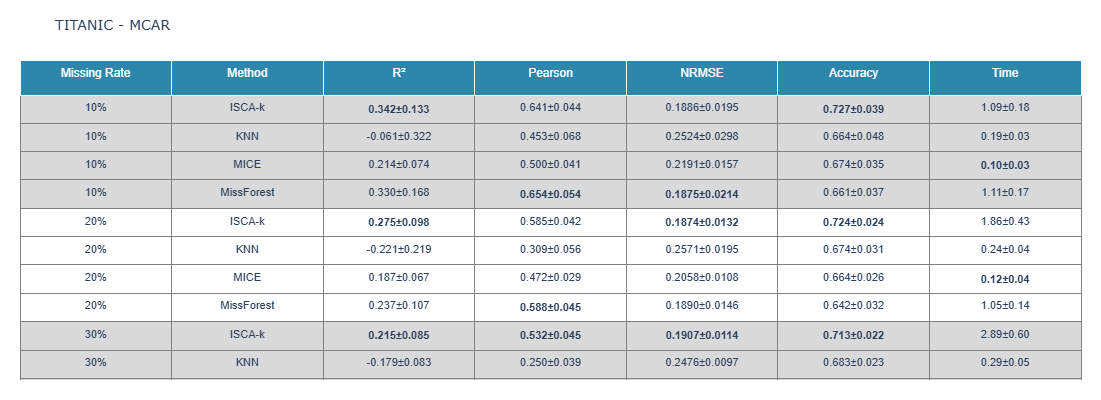

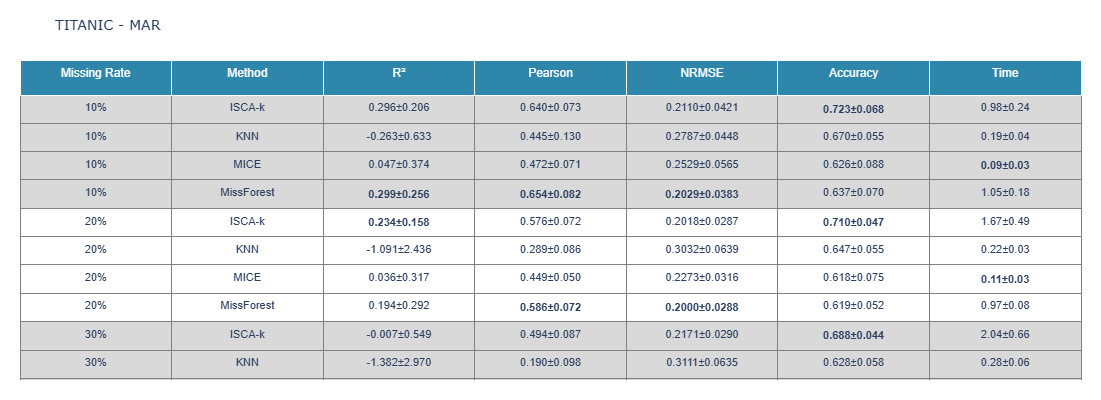

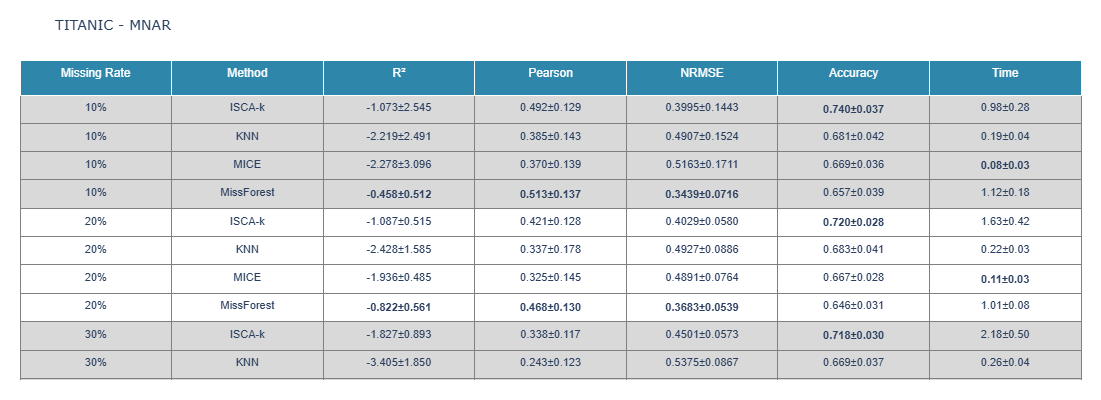

In [272]:
for mechanism in MECHANISMS:
    display_results_table(results_titanic, mechanism, "TITANIC")


MCAR - 30%:


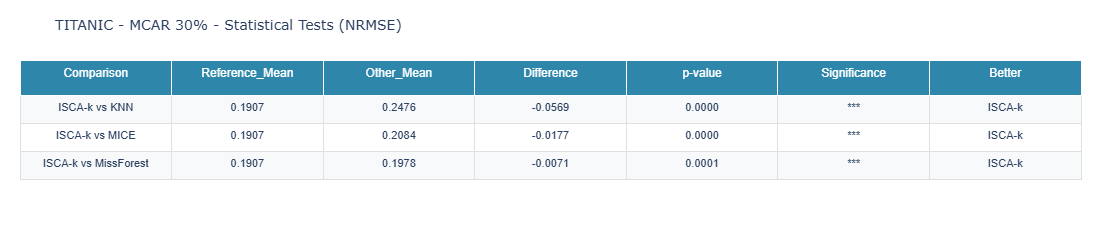


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 3/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MICE: p=0.0000 ***
  - vs MissForest: p=0.0001 ***

MAR - 30%:


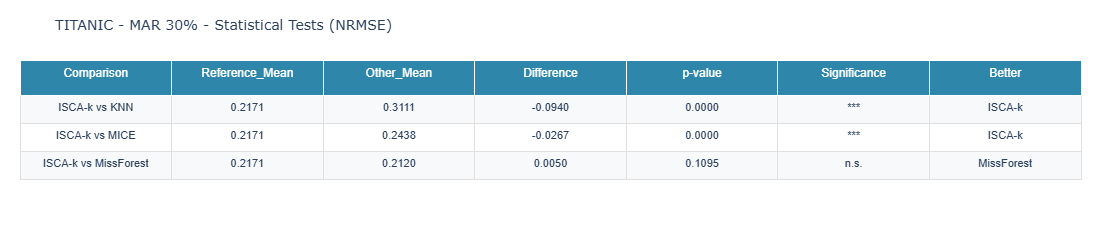


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 2/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MICE: p=0.0000 ***

MNAR - 30%:


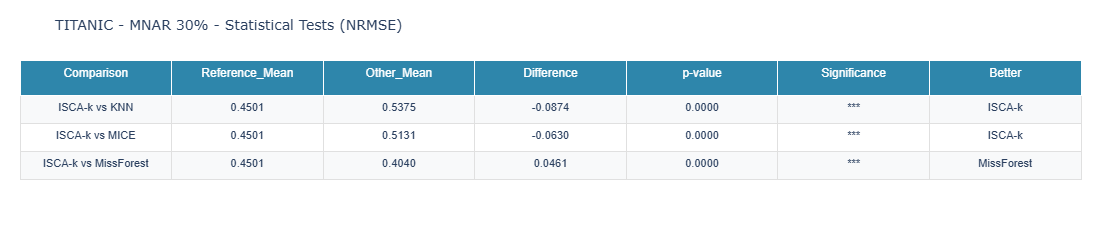


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 3/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MICE: p=0.0000 ***
  - vs MissForest: p=0.0000 ***



TESTE DE FRIEDMAN - TITANIC
MCAR 30% - NRMSE

Estatística: 114.2640
p-value: 0.0000
Resultado: DIFERENÇAS SIGNIFICATIVAS entre métodos (p < 0.05)

Ranking médio (1=melhor):
  ISCA-k: 1.42
  KNN: 4.00
  MICE: 2.68
  MissForest: 1.90

Ordem: ISCA-k > MissForest > MICE > KNN


In [274]:
# Wilcoxon para 30% em cada mecanismo
for mechanism in MECHANISMS:
    print(f"\n{mechanism} - 30%:")
    display_statistical_tests(results_titanic, mechanism, 0.30, "TITANIC", metric='NRMSE')

# Friedman test para 30% MCAR
print("\n")
display_friedman_results(results_titanic, 'MCAR', 0.30, "TITANIC", metric='NRMSE')


Gerando curvas de degradação...


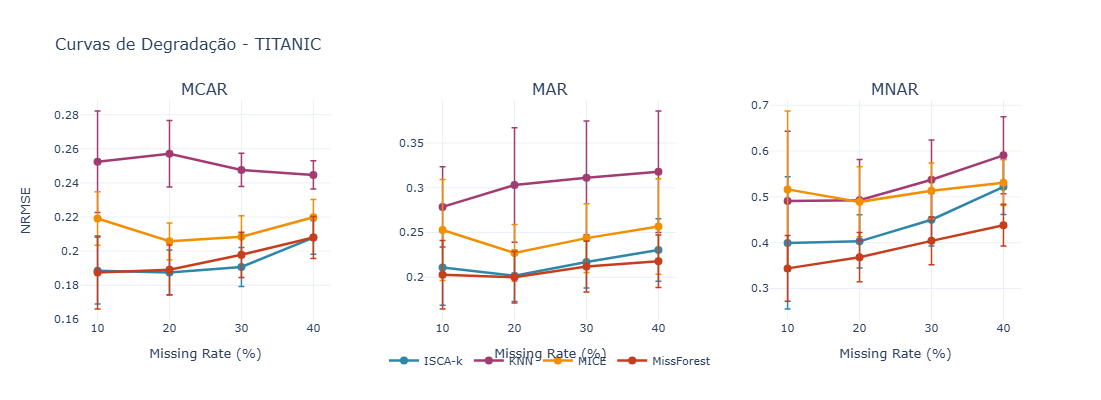

Gerando comparação de métodos...


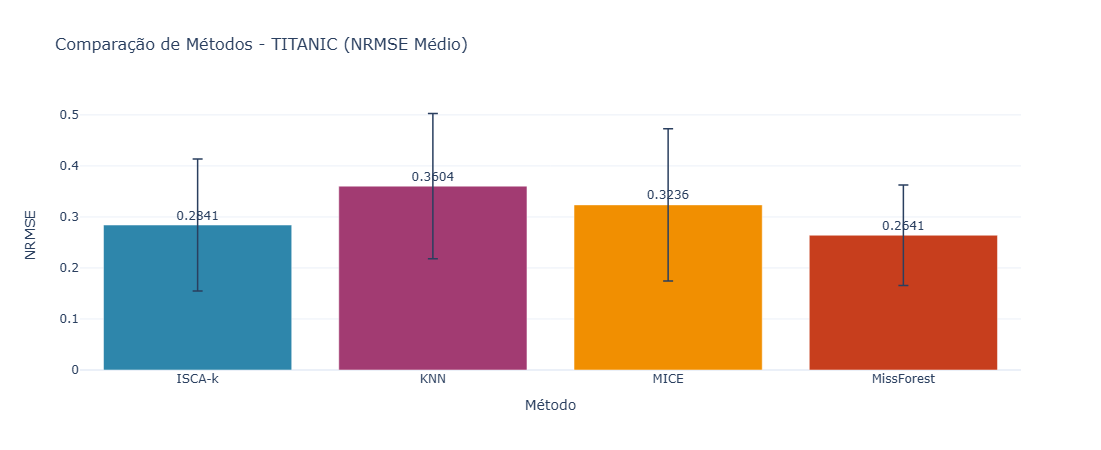

In [276]:
print("\nGerando curvas de degradação...")
plot_degradation_curves(results_titanic, "TITANIC", metric='NRMSE')

print("Gerando comparação de métodos...")
plot_method_comparison(results_titanic, "TITANIC")

##### CREDIT APPROVAL

In [232]:
import pandas as pd
import numpy as np
import time
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [234]:
# Carregar dataset Credit Approval do UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"

# Nomes das colunas conforme UCI repository
column_names = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 
                'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']

data_credit_raw = pd.read_csv(url, header=None, names=column_names, na_values='?')

print(f"\nShape original: {data_credit_raw.shape}")
print(f"\nColunas: {list(data_credit_raw.columns)}")
print(f"\nTipos originais:\n{data_credit_raw.dtypes}")

# Tipos conforme UCI:
# A1: b, a (nominal)
# A2: continuous (numérico)
# A3: continuous (numérico)
# A4: u, y, l, t (nominal)
# A5: g, p, gg (nominal)
# A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff (nominal)
# A7: v, h, bb, j, n, z, dd, ff, o (nominal)
# A8: continuous (numérico)
# A9: t, f (binária)
# A10: t, f (binária)
# A11: continuous (numérico)
# A12: t, f (binária)
# A13: g, p, s (nominal)
# A14: continuous (numérico)
# A15: continuous (numérico)
# A16: +, - (target - NÃO USAR)

# Remover coluna target (A16)
features_to_use = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 
                   'A10', 'A11', 'A12', 'A13', 'A14', 'A15']

data_credit = data_credit_raw[features_to_use].copy()

print(f"\nMissings nativos por coluna:")
print(data_credit.isna().sum())

# Converter tipos corretos
# Numéricas
numeric_cols = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
for col in numeric_cols:
    data_credit[col] = pd.to_numeric(data_credit[col], errors='coerce')

print(f"\nTipos após conversão:")
print(data_credit.dtypes)

# Remover linhas com missings nativos
data_credit_complete = data_credit.dropna()

print(f"\nShape após remover missings nativos: {data_credit_complete.shape}")
print(f"Missings restantes: {data_credit_complete.isna().sum().sum()}")

# Verificar
assert data_credit_complete.isna().sum().sum() == 0, "Dataset ainda tem missings!"

print("\n✓ Dataset completo e limpo")
print(f"Shape final: {data_credit_complete.shape}")
print(f"\nPrimeiras linhas:")
print(data_credit_complete.head())
print(f"\nEstatísticas descritivas (numéricas):")
print(data_credit_complete[numeric_cols].describe())


Shape original: (690, 16)

Colunas: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']

Tipos originais:
A1      object
A2     float64
A3     float64
A4      object
A5      object
A6      object
A7      object
A8     float64
A9      object
A10     object
A11      int64
A12     object
A13     object
A14    float64
A15      int64
A16     object
dtype: object

Missings nativos por coluna:
A1     12
A2     12
A3      0
A4      6
A5      6
A6      9
A7      9
A8      0
A9      0
A10     0
A11     0
A12     0
A13     0
A14    13
A15     0
dtype: int64

Tipos após conversão:
A1      object
A2     float64
A3     float64
A4      object
A5      object
A6      object
A7      object
A8     float64
A9      object
A10     object
A11      int64
A12     object
A13     object
A14    float64
A15      int64
dtype: object

Shape após remover missings nativos: (653, 15)
Missings restantes: 0

✓ Dataset completo e limpo
Shape final: (653, 15)

Primeiras 

In [236]:
# IMPORTANTE: Credit Approval NÃO tem variáveis ordinais claras
# Todas as categóricas são NOMINAIS

force_categorical_credit = None  # Detectar automaticamente
force_ordinal_credit = None  # Não há ordinais neste dataset

print("\nforce_categorical:", force_categorical_credit)
print("force_ordinal:", force_ordinal_credit)
print("\nVariáveis detectadas automaticamente:")
print(f"  - Numéricas: {numeric_cols}")
print(f"  - Nominais: A1, A4, A5, A6, A7, A13 (categóricas)")
print(f"  - Binárias: A9, A10, A12")


force_categorical: None
force_ordinal: None

Variáveis detectadas automaticamente:
  - Numéricas: ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
  - Nominais: A1, A4, A5, A6, A7, A13 (categóricas)
  - Binárias: A9, A10, A12


In [278]:
def impute_iscak_credit(data_missing):
    """ISCA-k para CREDIT (misto)."""
    imputer = ISCAkCore(verbose=False)
    result = imputer.impute(
        data_missing,
        force_categorical=force_categorical_credit,
        force_ordinal=force_ordinal_credit,
        interactive=False
    )
    return result

def impute_knn_credit(data_missing, k=5):
    """
    KNN para CREDIT (misto).
    
    Estratégia: Label encode categóricas, one-hot, imputa, reverte tipos originais.
    """
    # Separar por tipo
    numeric_cols_knn = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
    categorical_cols_knn = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']
    
    # Label encode
    data_encoded = data_missing.copy()
    label_mappings = {}
    
    for col in categorical_cols_knn:
        unique_vals = data_encoded[col].dropna().unique()
        mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
        reverse_mapping = {idx: val for val, idx in mapping.items()}
        label_mappings[col] = mapping
        label_mappings[f'{col}_reverse'] = reverse_mapping
        data_encoded[col] = data_encoded[col].map(mapping)
    
    # One-hot encode
    encoded_dfs = []
    for col in categorical_cols_knn:
        dummies = pd.get_dummies(data_encoded[col], prefix=col, drop_first=False, dtype=float)
        mask = data_encoded[col].isna()
        dummies.loc[mask, :] = np.nan
        encoded_dfs.append(dummies)
    
    # Combinar
    data_for_knn = pd.concat([data_encoded[numeric_cols_knn]] + encoded_dfs, axis=1)
    
    # Standardizar numéricas
    means = data_for_knn[numeric_cols_knn].mean()
    stds = data_for_knn[numeric_cols_knn].std().replace(0, 1)
    data_for_knn[numeric_cols_knn] = (data_for_knn[numeric_cols_knn] - means) / stds
    
    # Imputar
    imputer = KNNImputer(n_neighbors=k, weights='distance')
    data_imputed_array = imputer.fit_transform(data_for_knn)
    data_imputed_knn = pd.DataFrame(
        data_imputed_array,
        columns=data_for_knn.columns,
        index=data_for_knn.index
    )
    
    # Inverse transform
    data_imputed_knn[numeric_cols_knn] = (data_imputed_knn[numeric_cols_knn] * stds) + means
    
    # Resultado
    result = pd.DataFrame(index=data_missing.index)
    result[numeric_cols_knn] = data_imputed_knn[numeric_cols_knn]
    
    # Reverter categóricas
    for col in categorical_cols_knn:
        dummy_cols = [c for c in data_imputed_knn.columns if c.startswith(f"{col}_")]
        if len(dummy_cols) > 0:
            dummy_values = data_imputed_knn[dummy_cols].values
            max_indices = dummy_values.argmax(axis=1)
            reverse_map = label_mappings[f'{col}_reverse']
            result[col] = [reverse_map[idx] for idx in max_indices]
    
    # Ordem original
    result = result[data_missing.columns]
    
    return result

def impute_mice_credit(data_missing, random_state=42):
    """MICE para CREDIT - BayesianRidge."""
    data_encoded = data_missing.copy()
    label_mappings = {}
    categorical_cols = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']
    
    for col in categorical_cols:
        unique_vals = data_encoded[col].dropna().unique()
        mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
        reverse_mapping = {idx: val for val, idx in mapping.items()}
        label_mappings[col] = mapping
        label_mappings[f'{col}_reverse'] = reverse_mapping
        data_encoded[col] = data_encoded[col].map(mapping)
    
    imputer = IterativeImputer(max_iter=10, random_state=random_state)
    data_imputed_array = imputer.fit_transform(data_encoded)
    data_imputed = pd.DataFrame(data_imputed_array, columns=data_encoded.columns, index=data_encoded.index)
    
    for col in categorical_cols:
        n_classes = len(label_mappings[col])
        data_imputed[col] = data_imputed[col].round().clip(0, n_classes - 1).astype(int)
        reverse_map = label_mappings[f'{col}_reverse']
        data_imputed[col] = data_imputed[col].map(reverse_map)
    
    return data_imputed

def impute_missforest_credit(data_missing, random_state=42):
    """MissForest para CREDIT - RandomForest."""
    data_encoded = data_missing.copy()
    label_mappings = {}
    categorical_cols = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']
    
    for col in categorical_cols:
        unique_vals = data_encoded[col].dropna().unique()
        mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
        reverse_mapping = {idx: val for val, idx in mapping.items()}
        label_mappings[col] = mapping
        label_mappings[f'{col}_reverse'] = reverse_mapping
        data_encoded[col] = data_encoded[col].map(mapping)
    
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10, random_state=random_state),
        max_iter=10, sample_posterior=False, random_state=random_state
    )
    data_imputed_array = imputer.fit_transform(data_encoded)
    data_imputed = pd.DataFrame(data_imputed_array, columns=data_encoded.columns, index=data_encoded.index)
    
    for col in categorical_cols:
        n_classes = len(label_mappings[col])
        data_imputed[col] = data_imputed[col].round().clip(0, n_classes - 1).astype(int)
        reverse_map = label_mappings[f'{col}_reverse']
        data_imputed[col] = data_imputed[col].map(reverse_map)
    
    return data_imputed

print("\n✓ Funções de imputação definidas:")
print("  - ISCA-k: sem force_ordinal (só nominais)")
print("  - KNN: one-hot → standardize → impute → reverse")
print("  - MICE: label encode → RandomForest → reverse")
print("  - MissForest: aproximado com MICE+RF")


✓ Funções de imputação definidas:
  - ISCA-k: sem force_ordinal (só nominais)
  - KNN: one-hot → standardize → impute → reverse
  - MICE: label encode → RandomForest → reverse
  - MissForest: aproximado com MICE+RF


In [280]:
# Reset dataset
data_credit = data_credit_complete.copy()

# Resultados
results_credit = {}

# TESTE: Limitar a 2 runs
TEST_MODE = False
MAX_TEST_RUNS = 2

if TEST_MODE:
    print(f"\n⚠️  MODO TESTE: Limitado a {MAX_TEST_RUNS} runs")
    total_runs = MAX_TEST_RUNS
else:
    total_runs = len(MECHANISMS) * len(MISSING_RATES) * len(SEEDS) * len(METHOD_ORDER)

current_run = 0

for mechanism in MECHANISMS:
    print(f"\n{mechanism}:")
    
    for missing_rate in MISSING_RATES:
        print(f"  Missing rate {int(missing_rate*100)}%: ", end="")
        
        for run_idx, seed in enumerate(SEEDS):
            
            # TESTE: Parar
            if TEST_MODE and current_run >= MAX_TEST_RUNS:
                print("\n⚠️  Limite de teste atingido, parando...")
                break
            
            # Introduzir missings
            if mechanism == 'MCAR':
                data_missing = introduce_mcar(data_credit, missing_rate, seed)
            elif mechanism == 'MAR':
                data_missing = introduce_mar(data_credit, missing_rate, seed)
            else:
                data_missing = introduce_mnar(data_credit, missing_rate, seed)
            
            missing_mask = data_missing.isna()
            
            # Testar cada método
            for method in METHOD_ORDER:
                current_run += 1
                
                try:
                    start_time = time.time()
                    
                    if method == 'ISCA-k':
                        data_imputed = impute_iscak_credit(data_missing)
                    
                    elif method == 'KNN':
                        # Grid search
                        best_result = None
                        best_metrics = None
                        best_k = None
                        
                        for k in [3, 5, 7, 9, 11]:
                            data_imputed_k = impute_knn_credit(data_missing, k=k)
                            metrics_k = calculate_metrics(data_credit, data_imputed_k, missing_mask)
                            
                            if best_metrics is None or (
                                not np.isnan(metrics_k.get('NRMSE', np.inf)) and 
                                metrics_k.get('NRMSE', np.inf) < best_metrics.get('NRMSE', np.inf)
                            ):
                                best_result = data_imputed_k
                                best_metrics = metrics_k
                                best_k = k
                        
                        data_imputed = best_result
                        elapsed_time = time.time() - start_time
                        
                        best_metrics['Time'] = elapsed_time
                        best_metrics['Best_k'] = best_k
                        
                        key = (mechanism, missing_rate, method)
                        if key not in results_credit:
                            results_credit[key] = []
                        results_credit[key].append(best_metrics)
                        
                        continue
                    
                    elif method == 'MICE':
                        data_imputed = impute_mice_credit(data_missing, random_state=seed)
                    
                    else:  # MissForest
                        data_imputed = impute_missforest_credit(data_missing, random_state=seed)
                    
                    elapsed_time = time.time() - start_time
                    
                    # Métricas
                    metrics = calculate_metrics(data_credit, data_imputed, missing_mask)
                    metrics['Time'] = elapsed_time
                    
                    # Guardar
                    key = (mechanism, missing_rate, method)
                    if key not in results_credit:
                        results_credit[key] = []
                    results_credit[key].append(metrics)
                
                except Exception as e:
                    print(f"\nERRO em {method}: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
            
            print(".", end="", flush=True)
        
        # TESTE: Parar
        if TEST_MODE and current_run >= MAX_TEST_RUNS:
            break
        
        print(" OK")
    
    # TESTE: Parar
    if TEST_MODE and current_run >= MAX_TEST_RUNS:
        break

print("\n✓ Benchmark completo!")


MCAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

MAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

MNAR:
  Missing rate 10%: .................................................. OK
  Missing rate 20%: .................................................. OK
  Missing rate 30%: .................................................. OK
  Missing rate 40%: .................................................. OK

✓ Benchmark completo!


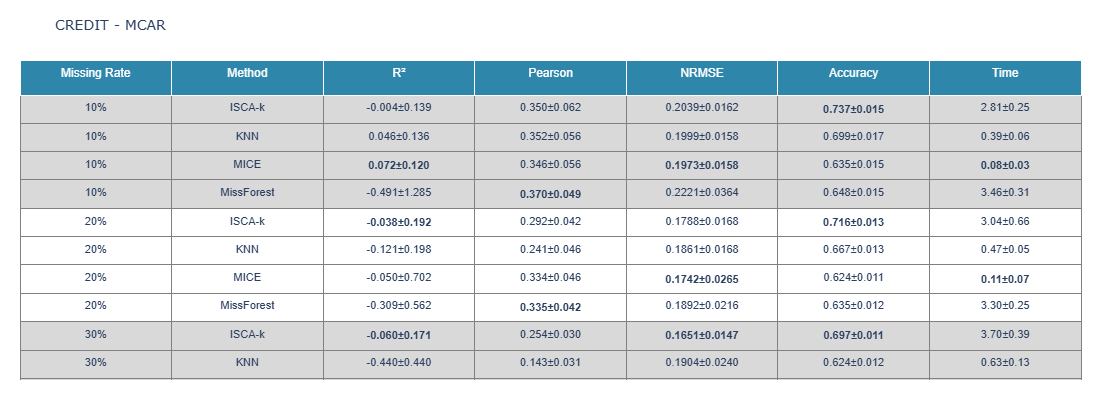

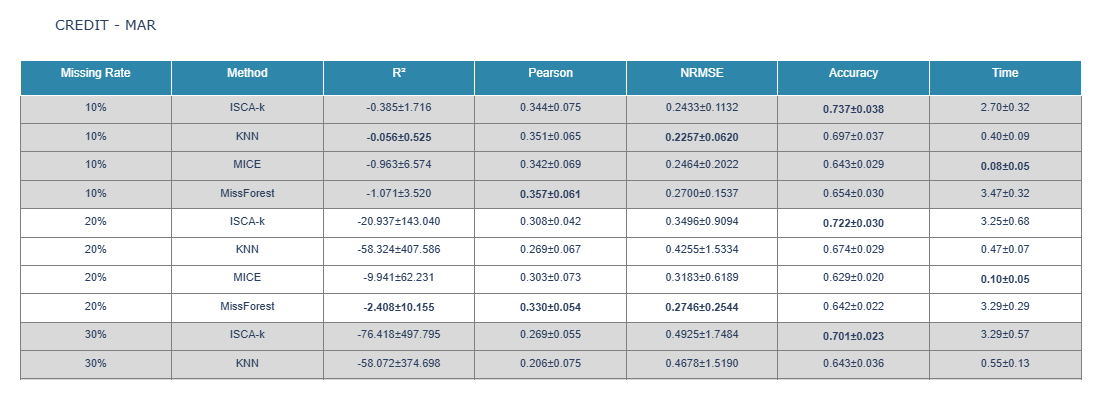

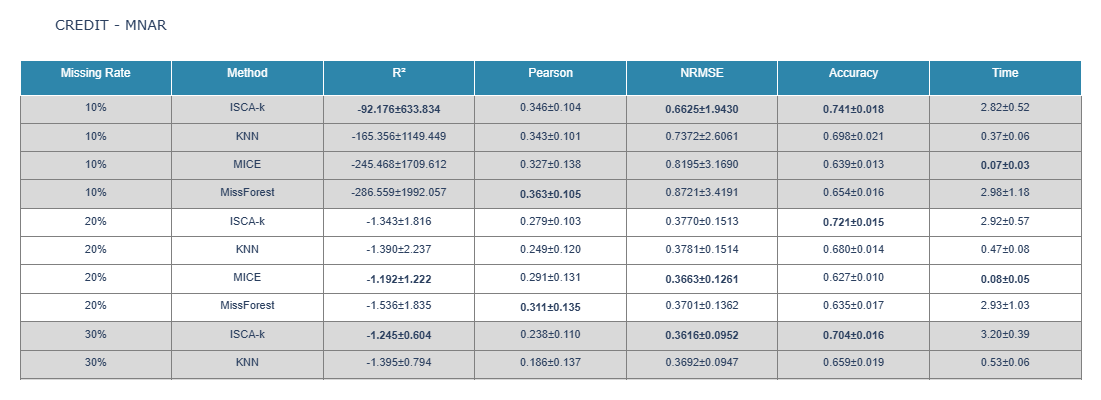

In [282]:
for mechanism in MECHANISMS:
    display_results_table(results_credit, mechanism, "CREDIT")


MCAR - 30%:


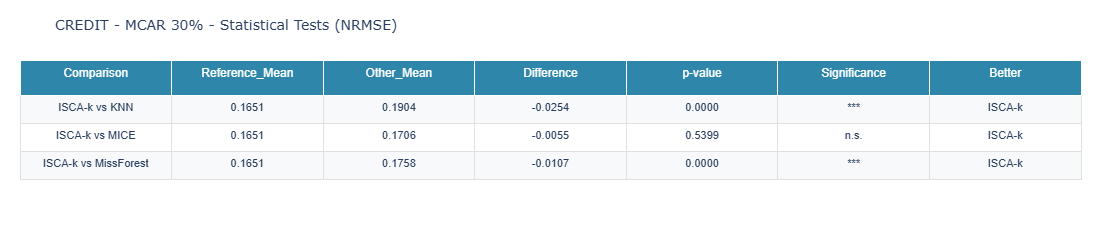


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 2/3 comparações:
  - vs KNN: p=0.0000 ***
  - vs MissForest: p=0.0000 ***

MAR - 30%:


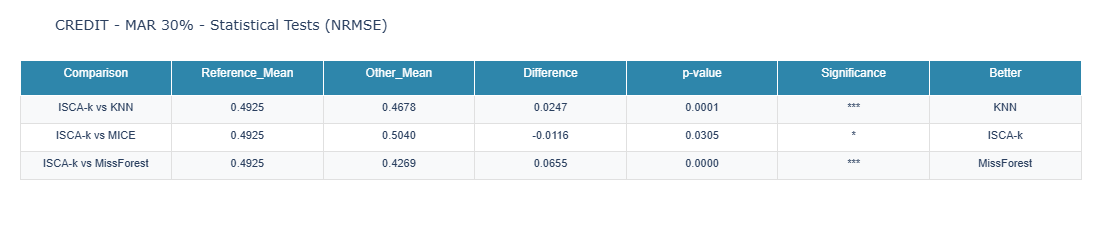


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

ISCA-k apresenta diferenças significativas em 3/3 comparações:
  - vs KNN: p=0.0001 ***
  - vs MICE: p=0.0305 *
  - vs MissForest: p=0.0000 ***

MNAR - 30%:


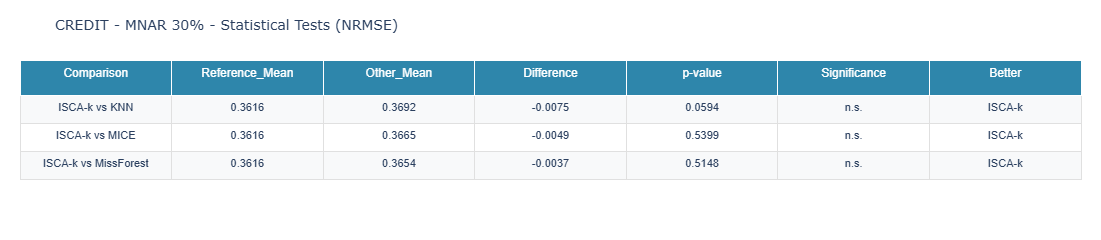


Interpretação dos resultados (NRMSE):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

Nenhuma diferença estatisticamente significativa detectada.



TESTE DE FRIEDMAN - CREDIT
MCAR 30% - NRMSE

Estatística: 66.3120
p-value: 0.0000
Resultado: DIFERENÇAS SIGNIFICATIVAS entre métodos (p < 0.05)

Ranking médio (1=melhor):
  ISCA-k: 1.88
  KNN: 3.70
  MICE: 1.88
  MissForest: 2.54

Ordem: ISCA-k > MICE > MissForest > KNN


In [284]:
for mechanism in MECHANISMS:
    print(f"\n{mechanism} - 30%:")
    display_statistical_tests(results_credit, mechanism, 0.30, "CREDIT", metric='NRMSE')

print("\n")
display_friedman_results(results_credit, 'MCAR', 0.30, "CREDIT", metric='NRMSE')


Gerando curvas de degradação...


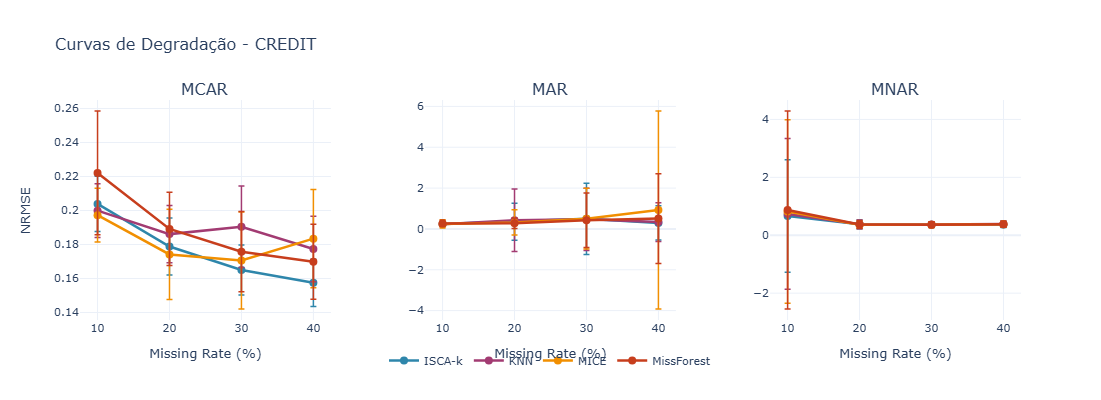

Gerando comparação de métodos...


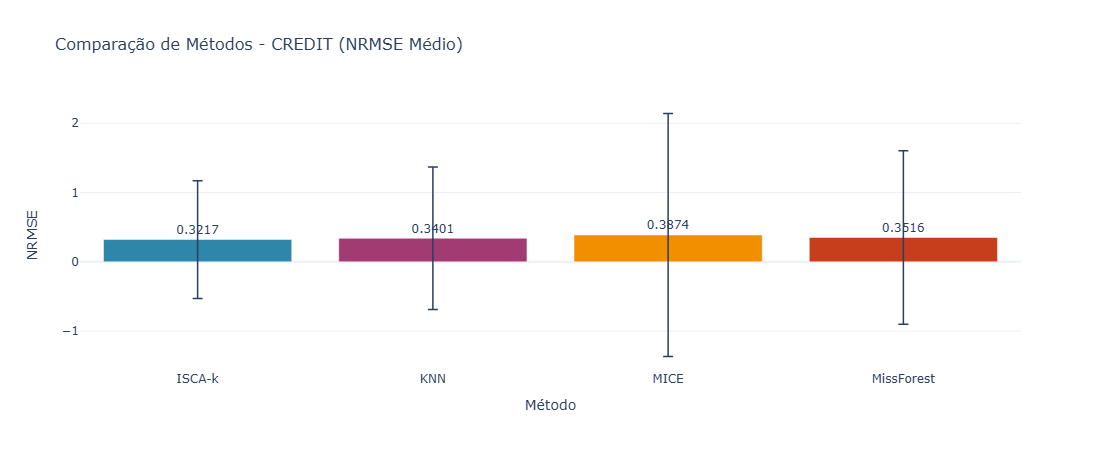

In [286]:
print("\nGerando curvas de degradação...")
plot_degradation_curves(results_credit, "CREDIT", metric='NRMSE')

print("Gerando comparação de métodos...")
plot_method_comparison(results_credit, "CREDIT")

#### Datasets Categóricos

##### MUSHROOM

In [248]:
import pandas as pd
import numpy as np
import time
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [250]:
# Carregar dataset Mushroom do UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

# Nomes das colunas conforme UCI
column_names = [
    'class',  # target (edible=e, poisonous=p) - NÃO USAR
    'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color',
    'ring-number', 'ring-type', 'spore-print-color',
    'population', 'habitat'
]

data_mushroom_raw = pd.read_csv(url, header=None, names=column_names, na_values='?')

print(f"\nShape original: {data_mushroom_raw.shape}")
print(f"\nColunas: {list(data_mushroom_raw.columns)}")

# Remover coluna target (class)
features_to_use = [col for col in column_names if col != 'class']

data_mushroom = data_mushroom_raw[features_to_use].copy()

print(f"\nMissings nativos por coluna:")
missing_counts = data_mushroom.isna().sum()
print(missing_counts[missing_counts > 0])

# Remover coluna 'stalk-root' que tem muitos missings (2480)
# E remover 'veil-type' que é constante (sempre 'p')
data_mushroom = data_mushroom.drop(['stalk-root', 'veil-type'], axis=1)

print(f"\nColunas após remover stalk-root e veil-type:")
print(list(data_mushroom.columns))

# Verificar e remover linhas com missings restantes (se houver)
data_mushroom_complete = data_mushroom.dropna()

print(f"\nShape após remover missings nativos: {data_mushroom_complete.shape}")
print(f"Missings restantes: {data_mushroom_complete.isna().sum().sum()}")

# Verificar
assert data_mushroom_complete.isna().sum().sum() == 0, "Dataset ainda tem missings!"

print("\n✓ Dataset completo e limpo")
print(f"Shape final: {data_mushroom_complete.shape}")
print(f"Total features: {data_mushroom_complete.shape[1]} (todas categóricas nominais)")

print(f"\nPrimeiras linhas:")
print(data_mushroom_complete.head())

print(f"\nTipos de dados:")
print(data_mushroom_complete.dtypes)

print(f"\nNúmero de categorias únicas por feature:")
for col in data_mushroom_complete.columns:
    print(f"  {col}: {data_mushroom_complete[col].nunique()} categorias")


Shape original: (8124, 23)

Colunas: ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

Missings nativos por coluna:
stalk-root    2480
dtype: int64

Colunas após remover stalk-root e veil-type:
['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

Shape após remover missings nativos: (8124, 20)
Missings restantes: 0

✓ Dataset completo e limpo
Shape final: (8124, 20)
Total features: 20 (todas c

In [252]:
force_categorical_mushroom = None  # Auto-detect (todas são object)
force_ordinal_mushroom = None      # Nenhuma ordinal

print("\nforce_categorical:", force_categorical_mushroom)
print("force_ordinal:", force_ordinal_mushroom)
print("\nVariáveis: TODAS nominais (20 features categóricas)")
print("  - Nenhuma numérica")
print("  - Nenhuma ordinal")
print("  - Todas nominais/binárias")


force_categorical: None
force_ordinal: None

Variáveis: TODAS nominais (20 features categóricas)
  - Nenhuma numérica
  - Nenhuma ordinal
  - Todas nominais/binárias


In [288]:
def impute_iscak_mushroom(data_missing):
    """ISCA-k para MUSHROOM (categórico puro)."""
    imputer = ISCAkCore(verbose=False)
    result = imputer.impute(
        data_missing,
        force_categorical=force_categorical_mushroom,
        force_ordinal=force_ordinal_mushroom,
        interactive=False
    )
    return result

def impute_knn_mushroom(data_missing, k=5):
    """
    KNN para MUSHROOM (categórico puro).
    
    Estratégia: ONE-HOT ENCODING
    - 20 features categóricas → ~100+ features binárias
    - KNN imputa
    - Reverte para categóricas originais
    """
    # Label encode TODAS as features
    data_encoded = data_missing.copy()
    label_mappings = {}
    all_cols = data_missing.columns.tolist()
    
    for col in all_cols:
        unique_vals = data_encoded[col].dropna().unique()
        mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
        reverse_mapping = {idx: val for val, idx in mapping.items()}
        label_mappings[col] = mapping
        label_mappings[f'{col}_reverse'] = reverse_mapping
        data_encoded[col] = data_encoded[col].map(mapping)
    
    # One-hot encode TODAS
    encoded_dfs = []
    for col in all_cols:
        dummies = pd.get_dummies(data_encoded[col], prefix=col, drop_first=False, dtype=float)
        mask = data_encoded[col].isna()
        dummies.loc[mask, :] = np.nan
        encoded_dfs.append(dummies)
    
    # Combinar todas as dummies
    data_for_knn = pd.concat(encoded_dfs, axis=1)
    
    print(f"  [KNN] One-hot: {data_missing.shape[1]} features → {data_for_knn.shape[1]} features")
    
    # Imputar (SEM standardização - são binárias)
    imputer = KNNImputer(n_neighbors=k, weights='distance')
    data_imputed_array = imputer.fit_transform(data_for_knn)
    data_imputed_knn = pd.DataFrame(
        data_imputed_array,
        columns=data_for_knn.columns,
        index=data_for_knn.index
    )
    
    # Reverter categóricas
    result = pd.DataFrame(index=data_missing.index)
    
    for col in all_cols:
        dummy_cols = [c for c in data_imputed_knn.columns if c.startswith(f"{col}_")]
        if len(dummy_cols) > 0:
            # Escolher categoria com maior valor
            dummy_values = data_imputed_knn[dummy_cols].values
            max_indices = dummy_values.argmax(axis=1)
            reverse_map = label_mappings[f'{col}_reverse']
            result[col] = [reverse_map[idx] for idx in max_indices]
    
    return result

def impute_mice_mushroom(data_missing, random_state=42):
    """MICE para MUSHROOM - BayesianRidge."""
    data_encoded = data_missing.copy()
    label_mappings = {}
    all_cols = data_missing.columns.tolist()
    
    for col in all_cols:
        unique_vals = data_encoded[col].dropna().unique()
        mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
        reverse_mapping = {idx: val for val, idx in mapping.items()}
        label_mappings[col] = mapping
        label_mappings[f'{col}_reverse'] = reverse_mapping
        data_encoded[col] = data_encoded[col].map(mapping)
    
    imputer = IterativeImputer(max_iter=5, random_state=random_state)
    data_imputed_array = imputer.fit_transform(data_encoded)
    data_imputed = pd.DataFrame(data_imputed_array, columns=data_encoded.columns, index=data_encoded.index)
    
    for col in all_cols:
        n_classes = len(label_mappings[col])
        data_imputed[col] = data_imputed[col].round().clip(0, n_classes - 1).astype(int)
        reverse_map = label_mappings[f'{col}_reverse']
        data_imputed[col] = data_imputed[col].map(reverse_map)
    
    return data_imputed

def impute_missforest_mushroom(data_missing, random_state=42):
    """MissForest para MUSHROOM - RandomForestClassifier."""
    data_encoded = data_missing.copy()
    label_mappings = {}
    all_cols = data_missing.columns.tolist()
    
    for col in all_cols:
        unique_vals = data_encoded[col].dropna().unique()
        mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
        reverse_mapping = {idx: val for val, idx in mapping.items()}
        label_mappings[col] = mapping
        label_mappings[f'{col}_reverse'] = reverse_mapping
        data_encoded[col] = data_encoded[col].map(mapping)
    
    imputer = IterativeImputer(
        estimator=RandomForestClassifier(n_estimators=5, random_state=random_state, max_depth=10),
        max_iter=5, sample_posterior=False, random_state=random_state
    )
    data_imputed_array = imputer.fit_transform(data_encoded)
    data_imputed = pd.DataFrame(data_imputed_array, columns=data_encoded.columns, index=data_encoded.index)
    
    for col in all_cols:
        n_classes = len(label_mappings[col])
        data_imputed[col] = data_imputed[col].round().clip(0, n_classes - 1).astype(int)
        reverse_map = label_mappings[f'{col}_reverse']
        data_imputed[col] = data_imputed[col].map(reverse_map)
    
    return data_imputed

print("\n✓ Funções de imputação definidas:")
print("  - ISCA-k: detecção automática (todas nominais)")
print("  - KNN: one-hot encode (~100 features) → impute → reverse")
print("  - MICE: label encode → RandomForestClassifier → reverse")
print("  - MissForest: aproximado (MICE+RFC)")
print("\n⚠️  AVISO: One-hot encoding cria ~100 features - pode ser lento!")


✓ Funções de imputação definidas:
  - ISCA-k: detecção automática (todas nominais)
  - KNN: one-hot encode (~100 features) → impute → reverse
  - MICE: label encode → RandomForestClassifier → reverse
  - MissForest: aproximado (MICE+RFC)

⚠️  AVISO: One-hot encoding cria ~100 features - pode ser lento!


In [290]:
# Reset dataset
data_mushroom = data_mushroom_complete.copy()

# Resultados
results_mushroom = {}

# TESTE: Limitar a 2 runs
TEST_MODE = False
MAX_TEST_RUNS = 2

# OTIMIZAÇÃO: Reduzir runs totais de 50 para 5
SEEDS_MUSHROOM = [42, 123, 456, 789, 101]  # 5 seeds em vez de 50

if TEST_MODE:
    print(f"\n⚠️  MODO TESTE: Limitado a {MAX_TEST_RUNS} runs")
    total_runs = MAX_TEST_RUNS
else:
    # Usar apenas 5 seeds para Mushroom (em vez de len(SEEDS))
    total_runs = len(MECHANISMS) * len(MISSING_RATES) * len(SEEDS_MUSHROOM) * len(METHOD_ORDER)
    print(f"\n⚠️  MUSHROOM OTIMIZADO: 5 runs por configuração (em vez de 50)")

current_run = 0

for mechanism in MECHANISMS:
    print(f"\n{mechanism}:")
    
    for missing_rate in MISSING_RATES:
        print(f"  Missing rate {int(missing_rate*100)}%: ", end="")
        
        # Usar SEEDS_MUSHROOM em vez de SEEDS
        seeds_to_use = SEEDS if TEST_MODE else SEEDS_MUSHROOM
        
        for run_idx, seed in enumerate(seeds_to_use):
            
            # TESTE: Parar
            if TEST_MODE and current_run >= MAX_TEST_RUNS:
                print("\n⚠️  Limite de teste atingido, parando...")
                break
            
            # Introduzir missings
            if mechanism == 'MCAR':
                data_missing = introduce_mcar(data_mushroom, missing_rate, seed)
            elif mechanism == 'MAR':
                data_missing = introduce_mar(data_mushroom, missing_rate, seed)
            else:
                data_missing = introduce_mnar(data_mushroom, missing_rate, seed)
            
            missing_mask = data_missing.isna()
            
            # Testar cada método
            for method in METHOD_ORDER:
                current_run += 1
                
                try:
                    start_time = time.time()
                    
                    if method == 'ISCA-k':
                        data_imputed = impute_iscak_mushroom(data_missing)
                    
                    elif method == 'KNN':
                        # Grid search REDUZIDO para Mushroom (só 3 valores de k)
                        best_result = None
                        best_metrics = None
                        best_k = None
                        
                        # OTIMIZAÇÃO: testar apenas k=[3, 7, 11] em vez de [3,5,7,9,11]
                        k_values = [3, 7, 11]
                        
                        for k in k_values:
                            data_imputed_k = impute_knn_mushroom(data_missing, k=k)
                            metrics_k = calculate_metrics(data_mushroom, data_imputed_k, missing_mask)
                            
                            # Para categórico: escolher k com melhor Accuracy
                            if best_metrics is None or (
                                not np.isnan(metrics_k.get('Accuracy', 0)) and 
                                metrics_k.get('Accuracy', 0) > best_metrics.get('Accuracy', 0)
                            ):
                                best_result = data_imputed_k
                                best_metrics = metrics_k
                                best_k = k
                        
                        data_imputed = best_result
                        elapsed_time = time.time() - start_time
                        
                        best_metrics['Time'] = elapsed_time
                        best_metrics['Best_k'] = best_k
                        
                        key = (mechanism, missing_rate, method)
                        if key not in results_mushroom:
                            results_mushroom[key] = []
                        results_mushroom[key].append(best_metrics)
                        
                        continue
                    
                    elif method == 'MICE':
                        data_imputed = impute_mice_mushroom(data_missing, random_state=seed)
                    
                    else:  # MissForest
                        data_imputed = impute_missforest_mushroom(data_missing, random_state=seed)
                    
                    elapsed_time = time.time() - start_time
                    
                    # Métricas
                    metrics = calculate_metrics(data_mushroom, data_imputed, missing_mask)
                    metrics['Time'] = elapsed_time
                    
                    # Guardar
                    key = (mechanism, missing_rate, method)
                    if key not in results_mushroom:
                        results_mushroom[key] = []
                    results_mushroom[key].append(metrics)
                
                except Exception as e:
                    print(f"\nERRO em {method}: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
            
            print(".", end="", flush=True)
        
        # TESTE: Parar
        if TEST_MODE and current_run >= MAX_TEST_RUNS:
            break
        
        print(" OK")
    
    # TESTE: Parar
    if TEST_MODE and current_run >= MAX_TEST_RUNS:
        break

print("\n✓ Benchmark completo!")


⚠️  MUSHROOM OTIMIZADO: 5 runs por configuração (em vez de 50)

MCAR:
  Missing rate 10%:   [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features
.  [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features
.  [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features
.  [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features
.  [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features
. OK
  Missing rate 20%:   [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features
.  [KNN] One-hot: 20 features → 111 features
  [KNN] One-hot: 20 features → 111 features

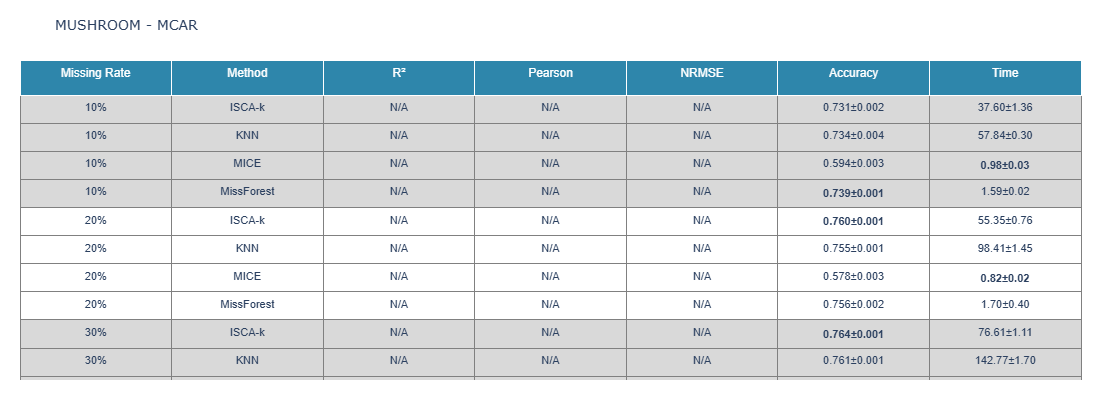

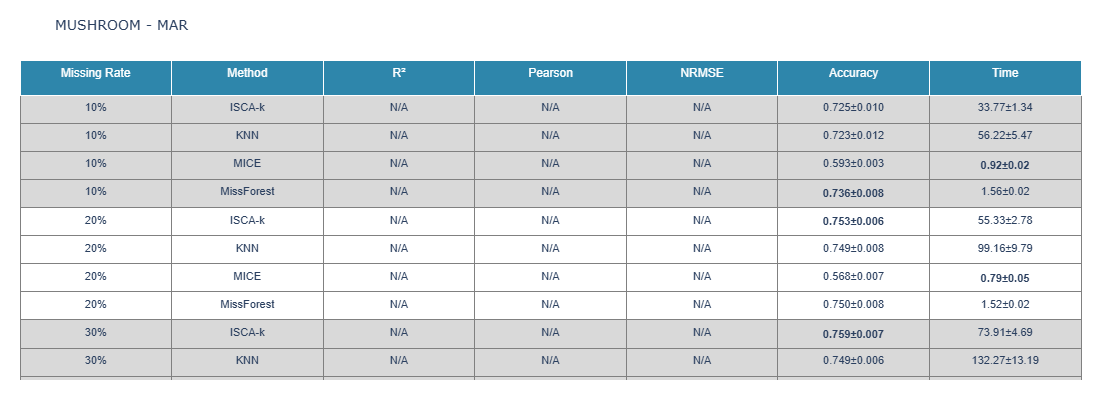

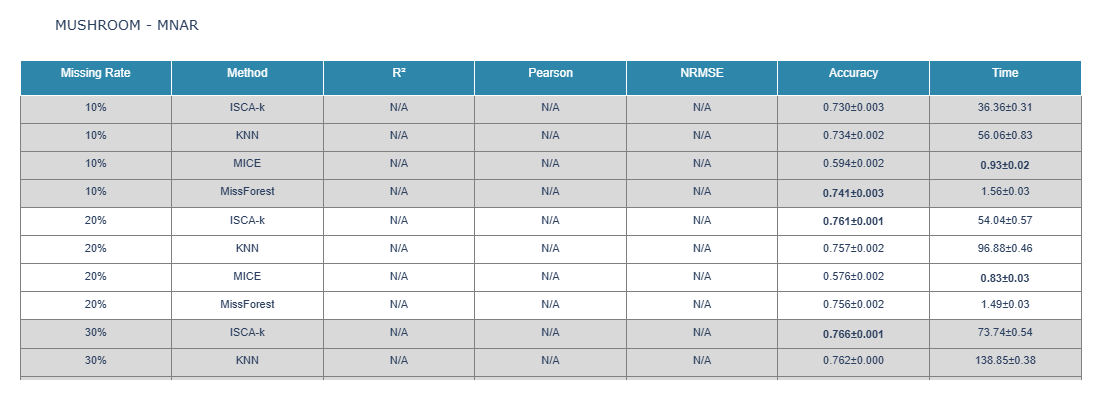

In [292]:
for mechanism in MECHANISMS:
    display_results_table(results_mushroom, mechanism, "MUSHROOM")


MCAR - 30%:


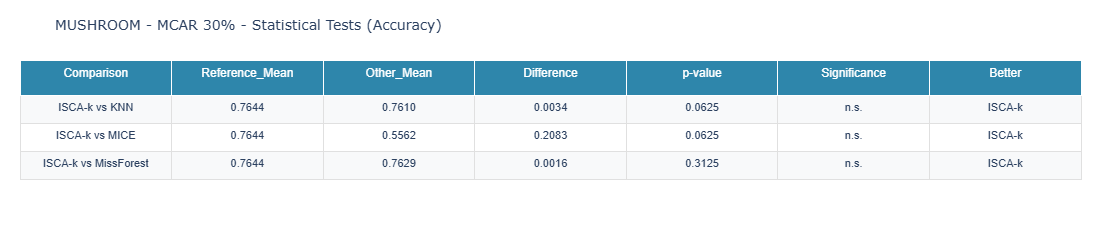


Interpretação dos resultados (Accuracy):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

Nenhuma diferença estatisticamente significativa detectada.

MAR - 30%:


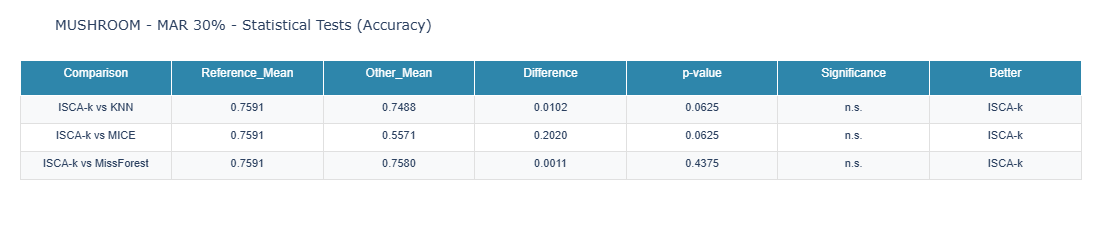


Interpretação dos resultados (Accuracy):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

Nenhuma diferença estatisticamente significativa detectada.

MNAR - 30%:


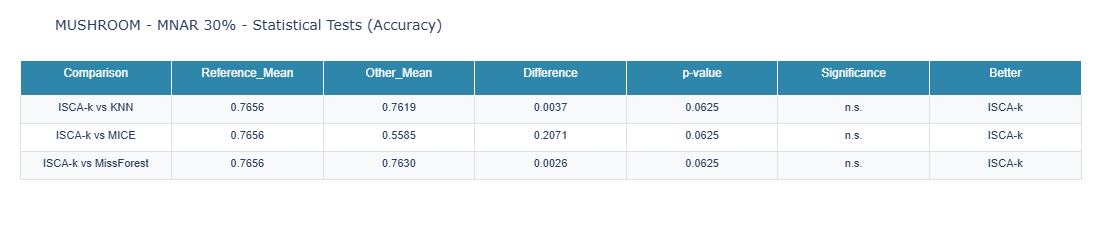


Interpretação dos resultados (Accuracy):
Significância: *** p<0.001, ** p<0.01, * p<0.05, n.s. = não significativo

Nenhuma diferença estatisticamente significativa detectada.



TESTE DE FRIEDMAN - MUSHROOM
MCAR 30% - Accuracy

Estatística: 12.1200
p-value: 0.0070
Resultado: DIFERENÇAS SIGNIFICATIVAS entre métodos (p < 0.05)

Ranking médio (1=melhor):
  ISCA-k: 1.40
  KNN: 2.80
  MICE: 4.00
  MissForest: 1.80

Ordem: ISCA-k > MissForest > KNN > MICE


In [294]:
for mechanism in MECHANISMS:
    print(f"\n{mechanism} - 30%:")
    display_statistical_tests(results_mushroom, mechanism, 0.30, "MUSHROOM", metric='Accuracy')

print("\n")
display_friedman_results(results_mushroom, 'MCAR', 0.30, "MUSHROOM", metric='Accuracy')

### APMI